<a href="https://colab.research.google.com/github/Antares01/semester_project_ml_for_finance/blob/main/semester_project_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np 
import torch
from torch import nn
from torch.utils.data import DataLoader
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
!pip install optuna
import optuna
from optuna.trial import TrialState 

In [18]:
# option price generation parameters
TOT_OPTIONS = 6

# NN parameters
MC_STEPS = 2**14
EPOCHS = 50

#integration parameter
INTERVAL_LENGTH = 200

In [19]:
# options generated with tf finance on another notebook
prices = np.array([50.074627, 40.418575, 27.322807, 18.141014, 29.417988, 37.88154 ])

strikes = np.array([50.0, 60.0, 75.0, 110.0, 125.0, 135.0])

is_call_option = np.array([True, True, True, False, False, False])

prices_and_strikes = [ (prices[i], strikes[i], is_call_option[i]) for i in range(TOT_OPTIONS)]

In [20]:
#model generating function

def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 2, 4)
    layers = []

    in_features = 1
    #network width
    out_features = trial.suggest_int("n_width", 32, 1024)

    for i in range(n_layers - 1):
        
        layers.append(nn.Linear(in_features, out_features))
        activation_name = trial.suggest_categorical("activation_l{}".format(i), ["LeakyReLU", "Sigmoid", "Tanh"])
        activation = getattr(nn, activation_name)()
        layers.append(activation)

        in_features = out_features

    layers.append(nn.Linear(out_features, 1))
    last_layer_name = trial.suggest_categorical("last_layer", ["Sigmoid", "Softplus"])
    last_layer = getattr(nn, last_layer_name)()
    # vedi se inizializzare bias dell'ultimo layer
    layers.append(last_layer)

    return nn.Sequential(*layers)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [22]:
class OptionLoss(nn.Module):

    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
        self.relu = nn.ReLU()

    def forward(self, p_densities, prices, strikes, is_call_option, X):
        pricing_loss = 0
        mc_integral = 0
        payoff_function = lambda  j : self.relu(X - strikes[j])  if is_call_option[j] else self.relu(strikes[j] - X)
        for j in range(len(prices)):
          mc_price = payoff_function(j) * p_densities
          pricing_loss += (prices[j] -  (INTERVAL_LENGTH * mc_price.sum() / MC_STEPS) )**2 

        #print(pricing_loss)
        X_1 = torch.clone(X[1:])
        p_densities_1 = torch.clone(p_densities[1:])
        
        mc_integral = (X_1 - X[:-1]) * (p_densities_1 - p_densities[:-1])
        #print(self.beta * (1 - 0.5 * mc_integral.sum())**2)
        return pricing_loss  + self.beta * (1 - 0.5 * mc_integral.sum())**2
        

In [23]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)
    print(model)
    lr = trial.suggest_float("lr", 1e-7, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    beta = trial.suggest_float("beta", 1e-1, 100, log=True)
    loss_fn = OptionLoss(beta)
    batch_size = trial.suggest_int("batch_size", 2, 10)
    target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)
    loss_history = []
    for epoch in range(EPOCHS):
      for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(0, INTERVAL_LENGTH)
        #sorting important for the mc integral
        X, _ = torch.sort(X)
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e1)
        optimizer.step()
        loss_history.append(loss)
    
    return sum(loss_history) / EPOCHS

In [24]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, timeout=3600)


[I 2022-02-27 11:46:34,291] A new study created in memory with name: no-name-9a349702-0647-46c4-bdb2-10aa0d69bf65


Sequential(
  (0): Linear(in_features=1, out_features=988, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=988, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 11:46:35,759] Trial 0 finished with value: 24448678140.8559 and parameters: {'n_layers': 2, 'n_width': 988, 'activation_l0': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 1.2015300852635605e-06, 'beta': 9.931100210469163, 'batch_size': 2}. Best is trial 0 with value: 24448678140.8559.


Sequential(
  (0): Linear(in_features=1, out_features=414, bias=True)
  (1): Tanh()
  (2): Linear(in_features=414, out_features=1, bias=True)
  (3): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:46:36,159] Trial 1 finished with value: 10442616.854280703 and parameters: {'n_layers': 2, 'n_width': 414, 'activation_l0': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.027164861591266746, 'beta': 5.5743481885525, 'batch_size': 9}. Best is trial 1 with value: 10442616.854280703.


Sequential(
  (0): Linear(in_features=1, out_features=657, bias=True)
  (1): Tanh()
  (2): Linear(in_features=657, out_features=657, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=657, out_features=657, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=657, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:46:39,284] Trial 2 finished with value: 2749010.7730130195 and parameters: {'n_layers': 4, 'n_width': 657, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.005489360305142994, 'beta': 0.2637393547968236, 'batch_size': 9}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=849, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=849, out_features=849, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=849, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 11:46:44,251] Trial 3 finished with value: 42767899.64275601 and parameters: {'n_layers': 3, 'n_width': 849, 'activation_l0': 'LeakyReLU', 'activation_l1': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 3.098438070270782e-05, 'beta': 0.2749434806912482, 'batch_size': 5}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=865, bias=True)
  (1): Tanh()
  (2): Linear(in_features=865, out_features=1, bias=True)
  (3): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:46:44,967] Trial 4 finished with value: 23541774.458309907 and parameters: {'n_layers': 2, 'n_width': 865, 'activation_l0': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.00011228523597478256, 'beta': 4.52546787851144, 'batch_size': 6}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=890, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=890, out_features=890, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=890, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 11:46:52,471] Trial 5 finished with value: 163611115.29710564 and parameters: {'n_layers': 3, 'n_width': 890, 'activation_l0': 'LeakyReLU', 'activation_l1': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 5.516615177961443e-07, 'beta': 7.112648555514055, 'batch_size': 2}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=306, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=306, out_features=306, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=306, out_features=306, bias=True)
  (5): Tanh()
  (6): Linear(in_features=306, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:46:53,460] Trial 6 finished with value: 112533540.10520224 and parameters: {'n_layers': 4, 'n_width': 306, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Softplus', 'lr': 2.9768840287244503e-05, 'beta': 1.9210328814844202, 'batch_size': 9}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=711, bias=True)
  (1): Tanh()
  (2): Linear(in_features=711, out_features=711, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=711, out_features=711, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=711, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:46:59,912] Trial 7 finished with value: 163995915.99402785 and parameters: {'n_layers': 4, 'n_width': 711, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 1.0729175304999081e-07, 'beta': 0.524847688520931, 'batch_size': 5}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=595, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=595, out_features=1, bias=True)
  (3): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:00,609] Trial 8 finished with value: 2335605065.935905 and parameters: {'n_layers': 2, 'n_width': 595, 'activation_l0': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 2.542533078844734e-05, 'beta': 4.3214930511893, 'batch_size': 5}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=560, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=560, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 11:47:00,939] Trial 9 finished with value: 803843473.6796194 and parameters: {'n_layers': 2, 'n_width': 560, 'activation_l0': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 5.520049165481559e-05, 'beta': 56.69902356403085, 'batch_size': 7}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=55, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=55, out_features=55, bias=True)
  (3): Tanh()
  (4): Linear(in_features=55, out_features=55, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=55, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:01,272] Trial 10 finished with value: 5752598.580926432 and parameters: {'n_layers': 4, 'n_width': 55, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.043344011215104644, 'beta': 0.13256514161962002, 'batch_size': 10}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=252, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=252, out_features=252, bias=True)
  (3): Tanh()
  (4): Linear(in_features=252, out_features=252, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=252, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:02,055] Trial 11 finished with value: 41407859.49214848 and parameters: {'n_layers': 4, 'n_width': 252, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.08039733132909342, 'beta': 0.13291368406496015, 'batch_size': 10}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=34, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=34, out_features=34, bias=True)
  (3): Tanh()
  (4): Linear(in_features=34, out_features=34, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=34, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:02,377] Trial 12 finished with value: 20988775.188741595 and parameters: {'n_layers': 4, 'n_width': 34, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.004838898576688601, 'beta': 0.10629901800738005, 'batch_size': 8}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=169, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=169, out_features=169, bias=True)
  (3): Tanh()
  (4): Linear(in_features=169, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:02,775] Trial 13 finished with value: 4161569.210546928 and parameters: {'n_layers': 3, 'n_width': 169, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.001957932481616118, 'beta': 0.7931100156929781, 'batch_size': 10}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=685, bias=True)
  (1): Tanh()
  (2): Linear(in_features=685, out_features=685, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=685, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:04,387] Trial 14 finished with value: 7712629.802573928 and parameters: {'n_layers': 3, 'n_width': 685, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.0012344060736332485, 'beta': 0.9834951941777316, 'batch_size': 8}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:04,861] Trial 15 finished with value: 9383906.22588301 and parameters: {'n_layers': 3, 'n_width': 200, 'activation_l0': 'Sigmoid', 'activation_l1': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.0009682243928520657, 'beta': 0.613093827795643, 'batch_size': 10}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=427, bias=True)
  (1): Tanh()
  (2): Linear(in_features=427, out_features=427, bias=True)
  (3): Tanh()
  (4): Linear(in_features=427, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:05,759] Trial 16 finished with value: 3145757.0801796014 and parameters: {'n_layers': 3, 'n_width': 427, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.0021085960702447973, 'beta': 1.3086029723938155, 'batch_size': 7}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=427, bias=True)
  (1): Tanh()
  (2): Linear(in_features=427, out_features=427, bias=True)
  (3): Tanh()
  (4): Linear(in_features=427, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:06,670] Trial 17 finished with value: 57287022.25610403 and parameters: {'n_layers': 3, 'n_width': 427, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.0002471058563506667, 'beta': 18.602947709804447, 'batch_size': 7}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=434, bias=True)
  (1): Tanh()
  (2): Linear(in_features=434, out_features=434, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=434, out_features=434, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=434, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:08,200] Trial 18 finished with value: 5017982.997338743 and parameters: {'n_layers': 4, 'n_width': 434, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.008582041502998078, 'beta': 1.8074019088876863, 'batch_size': 7}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=695, bias=True)
  (1): Tanh()
  (2): Linear(in_features=695, out_features=695, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=695, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:11,451] Trial 19 finished with value: 2993556.987553131 and parameters: {'n_layers': 3, 'n_width': 695, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.00040378511859337886, 'beta': 0.3903698981087686, 'batch_size': 4}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=714, bias=True)
  (1): Tanh()
  (2): Linear(in_features=714, out_features=714, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=714, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:14,977] Trial 20 finished with value: 3237923.5524899648 and parameters: {'n_layers': 3, 'n_width': 714, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.00031063621511109407, 'beta': 0.31192819842651204, 'batch_size': 3}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=624, bias=True)
  (1): Tanh()
  (2): Linear(in_features=624, out_features=624, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=624, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:17,698] Trial 21 finished with value: 2849953.5161580252 and parameters: {'n_layers': 3, 'n_width': 624, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.004754057823163189, 'beta': 0.26689731395811694, 'batch_size': 4}. Best is trial 2 with value: 2749010.7730130195.


Sequential(
  (0): Linear(in_features=1, out_features=633, bias=True)
  (1): Tanh()
  (2): Linear(in_features=633, out_features=633, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=633, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:20,361] Trial 22 finished with value: 2142433.3249405106 and parameters: {'n_layers': 3, 'n_width': 633, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.011037433342844627, 'beta': 0.2902508550653733, 'batch_size': 4}. Best is trial 22 with value: 2142433.3249405106.


Sequential(
  (0): Linear(in_features=1, out_features=595, bias=True)
  (1): Tanh()
  (2): Linear(in_features=595, out_features=595, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=595, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:22,901] Trial 23 finished with value: 3244216.1689761253 and parameters: {'n_layers': 3, 'n_width': 595, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.01295471641645766, 'beta': 0.23513898251483784, 'batch_size': 4}. Best is trial 22 with value: 2142433.3249405106.


Sequential(
  (0): Linear(in_features=1, out_features=797, bias=True)
  (1): Tanh()
  (2): Linear(in_features=797, out_features=797, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=797, out_features=797, bias=True)
  (5): Tanh()
  (6): Linear(in_features=797, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:29,949] Trial 24 finished with value: 17575937.837647464 and parameters: {'n_layers': 4, 'n_width': 797, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.016679434863520255, 'beta': 0.2164690396043575, 'batch_size': 3}. Best is trial 22 with value: 2142433.3249405106.


Sequential(
  (0): Linear(in_features=1, out_features=506, bias=True)
  (1): Tanh()
  (2): Linear(in_features=506, out_features=506, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=506, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:47:32,059] Trial 25 finished with value: 3312297.2160045328 and parameters: {'n_layers': 3, 'n_width': 506, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.0035301060477551643, 'beta': 0.18341294201444344, 'batch_size': 4}. Best is trial 22 with value: 2142433.3249405106.


Sequential(
  (0): Linear(in_features=1, out_features=647, bias=True)
  (1): Tanh()
  (2): Linear(in_features=647, out_features=647, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=647, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 11:47:34,935] Trial 26 finished with value: 1980109.2023482507 and parameters: {'n_layers': 3, 'n_width': 647, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.08208705391431234, 'beta': 0.4482328429357738, 'batch_size': 3}. Best is trial 26 with value: 1980109.2023482507.


Sequential(
  (0): Linear(in_features=1, out_features=502, bias=True)
  (1): Tanh()
  (2): Linear(in_features=502, out_features=502, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=502, out_features=502, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=502, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:47:38,473] Trial 27 finished with value: 10525237.236068254 and parameters: {'n_layers': 4, 'n_width': 502, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.034957860241321095, 'beta': 0.47352995324735103, 'batch_size': 3}. Best is trial 26 with value: 1980109.2023482507.


Sequential(
  (0): Linear(in_features=1, out_features=777, bias=True)
  (1): Tanh()
  (2): Linear(in_features=777, out_features=777, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=777, out_features=777, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=777, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:47:41,927] Trial 28 finished with value: 2454998.5155563783 and parameters: {'n_layers': 4, 'n_width': 777, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05503799537336379, 'beta': 0.5578804259025806, 'batch_size': 6}. Best is trial 26 with value: 1980109.2023482507.


Sequential(
  (0): Linear(in_features=1, out_features=1021, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1021, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 11:47:43,341] Trial 29 finished with value: 3933107.8929998074 and parameters: {'n_layers': 2, 'n_width': 1021, 'activation_l0': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.09756319754318085, 'beta': 2.526220016676088, 'batch_size': 2}. Best is trial 26 with value: 1980109.2023482507.


Sequential(
  (0): Linear(in_features=1, out_features=775, bias=True)
  (1): Tanh()
  (2): Linear(in_features=775, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 11:47:43,782] Trial 30 finished with value: 516704072.05063474 and parameters: {'n_layers': 2, 'n_width': 775, 'activation_l0': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 7.471615864048062e-06, 'beta': 14.25984094500986, 'batch_size': 6}. Best is trial 26 with value: 1980109.2023482507.


Sequential(
  (0): Linear(in_features=1, out_features=649, bias=True)
  (1): Tanh()
  (2): Linear(in_features=649, out_features=649, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=649, out_features=649, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=649, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:47:49,133] Trial 31 finished with value: 908845.4954111075 and parameters: {'n_layers': 4, 'n_width': 649, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.012800042072261642, 'beta': 1.1966677540148705, 'batch_size': 3}. Best is trial 31 with value: 908845.4954111075.


Sequential(
  (0): Linear(in_features=1, out_features=952, bias=True)
  (1): Tanh()
  (2): Linear(in_features=952, out_features=952, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=952, out_features=952, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=952, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:47:58,502] Trial 32 finished with value: 673487.1934360773 and parameters: {'n_layers': 4, 'n_width': 952, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.023511203654087712, 'beta': 0.9827098564105511, 'batch_size': 3}. Best is trial 32 with value: 673487.1934360773.


Sequential(
  (0): Linear(in_features=1, out_features=913, bias=True)
  (1): Tanh()
  (2): Linear(in_features=913, out_features=913, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=913, out_features=913, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=913, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:48:12,459] Trial 33 finished with value: 1034491.5858517392 and parameters: {'n_layers': 4, 'n_width': 913, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.024526503852685372, 'beta': 1.1264227428838909, 'batch_size': 2}. Best is trial 32 with value: 673487.1934360773.


Sequential(
  (0): Linear(in_features=1, out_features=945, bias=True)
  (1): Tanh()
  (2): Linear(in_features=945, out_features=945, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=945, out_features=945, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=945, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:48:26,853] Trial 34 finished with value: 1287152.2575280154 and parameters: {'n_layers': 4, 'n_width': 945, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.028245481151162655, 'beta': 1.124507879424844, 'batch_size': 2}. Best is trial 32 with value: 673487.1934360773.


Sequential(
  (0): Linear(in_features=1, out_features=942, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=942, out_features=942, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=942, out_features=942, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=942, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:48:41,260] Trial 35 finished with value: 3910342.476538392 and parameters: {'n_layers': 4, 'n_width': 942, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.015940414084959907, 'beta': 1.1684896140299985, 'batch_size': 2}. Best is trial 32 with value: 673487.1934360773.


Sequential(
  (0): Linear(in_features=1, out_features=968, bias=True)
  (1): Tanh()
  (2): Linear(in_features=968, out_features=968, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=968, out_features=968, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=968, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:48:56,126] Trial 36 finished with value: 512175.8471935417 and parameters: {'n_layers': 4, 'n_width': 968, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.026230234805038343, 'beta': 3.0411391019727043, 'batch_size': 2}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=971, bias=True)
  (1): Tanh()
  (2): Linear(in_features=971, out_features=971, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=971, out_features=971, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=971, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:49:06,217] Trial 37 finished with value: 868184.3290215194 and parameters: {'n_layers': 4, 'n_width': 971, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.022143623816176006, 'beta': 3.251635932890957, 'batch_size': 3}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=999, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=999, out_features=999, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=999, out_features=999, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=999, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:49:17,031] Trial 38 finished with value: 2618585.729509541 and parameters: {'n_layers': 4, 'n_width': 999, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.007753615642363961, 'beta': 2.908466175452782, 'batch_size': 3}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=835, bias=True)
  (1): Tanh()
  (2): Linear(in_features=835, out_features=835, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=835, out_features=835, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=835, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:49:25,576] Trial 39 finished with value: 5448888.685017817 and parameters: {'n_layers': 4, 'n_width': 835, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0006356539530571739, 'beta': 7.324286578794126, 'batch_size': 3}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=963, bias=True)
  (1): Tanh()
  (2): Linear(in_features=963, out_features=963, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=963, out_features=963, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=963, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:49:36,431] Trial 40 finished with value: 96414109.04659633 and parameters: {'n_layers': 4, 'n_width': 963, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 3.2624813005082626e-06, 'beta': 3.874841819336992, 'batch_size': 5}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=888, bias=True)
  (1): Tanh()
  (2): Linear(in_features=888, out_features=888, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=888, out_features=888, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=888, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:49:48,563] Trial 41 finished with value: 890256.6574907408 and parameters: {'n_layers': 4, 'n_width': 888, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0289190830293753, 'beta': 1.7987936494526107, 'batch_size': 2}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=875, bias=True)
  (1): Tanh()
  (2): Linear(in_features=875, out_features=875, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=875, out_features=875, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=875, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:50:01,186] Trial 42 finished with value: 943556.608927403 and parameters: {'n_layers': 4, 'n_width': 875, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.023511585382212614, 'beta': 1.985562711794032, 'batch_size': 2}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=830, bias=True)
  (1): Tanh()
  (2): Linear(in_features=830, out_features=830, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=830, out_features=830, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=830, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:50:12,770] Trial 43 finished with value: 168644660.85907906 and parameters: {'n_layers': 4, 'n_width': 830, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.002756539616839478, 'beta': 6.302712621798943, 'batch_size': 2}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=892, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=892, out_features=892, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=892, out_features=892, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=892, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:50:21,009] Trial 44 finished with value: 23808826.39530889 and parameters: {'n_layers': 4, 'n_width': 892, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04406640775772201, 'beta': 1.7313213886272174, 'batch_size': 3}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Tanh()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:50:35,635] Trial 45 finished with value: 19304846.055306677 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.007283567015775518, 'beta': 2.867136292546333, 'batch_size': 2}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=997, bias=True)
  (1): Tanh()
  (2): Linear(in_features=997, out_features=997, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=997, out_features=997, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=997, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:50:45,869] Trial 46 finished with value: 961419.4807433035 and parameters: {'n_layers': 4, 'n_width': 997, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.014901501377389015, 'beta': 0.7301707278482138, 'batch_size': 3}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=753, bias=True)
  (1): Tanh()
  (2): Linear(in_features=753, out_features=753, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=753, out_features=753, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=753, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:50:52,221] Trial 47 finished with value: 1770614.8025488704 and parameters: {'n_layers': 4, 'n_width': 753, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05070326375589536, 'beta': 9.690420914478766, 'batch_size': 4}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=904, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=904, out_features=904, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=904, out_features=904, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=904, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:51:02,053] Trial 48 finished with value: 78090862.56479882 and parameters: {'n_layers': 4, 'n_width': 904, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 3.054469991432733e-07, 'beta': 1.5406143728505872, 'batch_size': 3}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=1023, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1023, out_features=1023, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=1023, out_features=1023, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1023, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:51:18,953] Trial 49 finished with value: 11749819.731462732 and parameters: {'n_layers': 4, 'n_width': 1023, 'activation_l0': 'LeakyReLU', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 9.883054829350171e-05, 'beta': 4.132374789065152, 'batch_size': 2}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=837, bias=True)
  (1): Tanh()
  (2): Linear(in_features=837, out_features=837, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=837, out_features=837, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=837, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:51:26,832] Trial 50 finished with value: 1720063.7461979585 and parameters: {'n_layers': 4, 'n_width': 837, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06001050486169749, 'beta': 0.8384914388644319, 'batch_size': 5}. Best is trial 36 with value: 512175.8471935417.


Sequential(
  (0): Linear(in_features=1, out_features=890, bias=True)
  (1): Tanh()
  (2): Linear(in_features=890, out_features=890, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=890, out_features=890, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=890, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:51:39,152] Trial 51 finished with value: 441924.4937063568 and parameters: {'n_layers': 4, 'n_width': 890, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.020856482592801526, 'beta': 2.3401740819727044, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=916, bias=True)
  (1): Tanh()
  (2): Linear(in_features=916, out_features=916, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=916, out_features=916, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=916, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:51:52,903] Trial 52 finished with value: 963028.9704021949 and parameters: {'n_layers': 4, 'n_width': 916, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02533843431927614, 'beta': 2.260479016632292, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=865, bias=True)
  (1): Tanh()
  (2): Linear(in_features=865, out_features=865, bias=True)
  (3): Tanh()
  (4): Linear(in_features=865, out_features=865, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=865, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:52:05,522] Trial 53 finished with value: 712697.4980218437 and parameters: {'n_layers': 4, 'n_width': 865, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.005894708963739019, 'beta': 3.6783943034419355, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=854, bias=True)
  (1): Tanh()
  (2): Linear(in_features=854, out_features=854, bias=True)
  (3): Tanh()
  (4): Linear(in_features=854, out_features=854, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=854, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:52:18,364] Trial 54 finished with value: 862055.203759353 and parameters: {'n_layers': 4, 'n_width': 854, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.001404779021832353, 'beta': 3.1723844792941573, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=948, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=948, out_features=948, bias=True)
  (3): Tanh()
  (4): Linear(in_features=948, out_features=948, bias=True)
  (5): Tanh()
  (6): Linear(in_features=948, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:52:33,648] Trial 55 finished with value: 1210226.3787425926 and parameters: {'n_layers': 4, 'n_width': 948, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.0013966449856723342, 'beta': 3.6289238309034286, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=809, bias=True)
  (1): Tanh()
  (2): Linear(in_features=809, out_features=809, bias=True)
  (3): Tanh()
  (4): Linear(in_features=809, out_features=809, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=809, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:52:44,876] Trial 56 finished with value: 1190577.1494364603 and parameters: {'n_layers': 4, 'n_width': 809, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.004813443190772665, 'beta': 5.402472479960027, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=858, bias=True)
  (1): Tanh()
  (2): Linear(in_features=858, out_features=858, bias=True)
  (3): Tanh()
  (4): Linear(in_features=858, out_features=858, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=858, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:52:53,395] Trial 57 finished with value: 1516334.5237644813 and parameters: {'n_layers': 4, 'n_width': 858, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0030355241061116216, 'beta': 5.038270774610186, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=977, bias=True)
  (1): Tanh()
  (2): Linear(in_features=977, out_features=977, bias=True)
  (3): Tanh()
  (4): Linear(in_features=977, out_features=977, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=977, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:53:09,185] Trial 58 finished with value: 722230.6710356202 and parameters: {'n_layers': 4, 'n_width': 977, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.006551894076419754, 'beta': 9.396546027641383, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=735, bias=True)
  (1): Tanh()
  (2): Linear(in_features=735, out_features=735, bias=True)
  (3): Tanh()
  (4): Linear(in_features=735, out_features=735, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=735, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:53:19,128] Trial 59 finished with value: 813592291.18108 and parameters: {'n_layers': 4, 'n_width': 735, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.0017632085882604868, 'beta': 43.113809517466755, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=864, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=864, out_features=864, bias=True)
  (3): Tanh()
  (4): Linear(in_features=864, out_features=864, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=864, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:53:31,833] Trial 60 finished with value: 19080739.60710572 and parameters: {'n_layers': 4, 'n_width': 864, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0006574216882446142, 'beta': 9.104378122905104, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=975, bias=True)
  (1): Tanh()
  (2): Linear(in_features=975, out_features=975, bias=True)
  (3): Tanh()
  (4): Linear(in_features=975, out_features=975, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=975, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:53:42,344] Trial 61 finished with value: 2509421.392583917 and parameters: {'n_layers': 4, 'n_width': 975, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.006267389133758826, 'beta': 3.0202560344096683, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=931, bias=True)
  (1): Tanh()
  (2): Linear(in_features=931, out_features=931, bias=True)
  (3): Tanh()
  (4): Linear(in_features=931, out_features=931, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=931, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:53:56,864] Trial 62 finished with value: 1138410.4274778212 and parameters: {'n_layers': 4, 'n_width': 931, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0078073548993608, 'beta': 17.54327780372149, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=974, bias=True)
  (1): Tanh()
  (2): Linear(in_features=974, out_features=974, bias=True)
  (3): Tanh()
  (4): Linear(in_features=974, out_features=974, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=974, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:07,444] Trial 63 finished with value: 746880.7633836642 and parameters: {'n_layers': 4, 'n_width': 974, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0039046752423137917, 'beta': 8.013311330921109, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1022, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1022, out_features=1022, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1022, out_features=1022, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1022, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:23,665] Trial 64 finished with value: 3735195.9269227167 and parameters: {'n_layers': 4, 'n_width': 1022, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.0037893900604214, 'beta': 13.62588365480849, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=369, bias=True)
  (1): Tanh()
  (2): Linear(in_features=369, out_features=369, bias=True)
  (3): Tanh()
  (4): Linear(in_features=369, out_features=369, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=369, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:26,123] Trial 65 finished with value: 5724562.45990463 and parameters: {'n_layers': 4, 'n_width': 369, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0007554737402826278, 'beta': 7.075415911156735, 'batch_size': 4}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=989, bias=True)
  (1): Tanh()
  (2): Linear(in_features=989, out_features=989, bias=True)
  (3): Tanh()
  (4): Linear(in_features=989, out_features=989, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=989, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:36,289] Trial 66 finished with value: 1229245.040903354 and parameters: {'n_layers': 4, 'n_width': 989, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.002228988618458054, 'beta': 2.3807069421809164, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=806, bias=True)
  (1): Tanh()
  (2): Linear(in_features=806, out_features=806, bias=True)
  (3): Tanh()
  (4): Linear(in_features=806, out_features=806, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=806, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:40,133] Trial 67 finished with value: 5393962.990186786 and parameters: {'n_layers': 4, 'n_width': 806, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.00020360969121461275, 'beta': 8.291162345574461, 'batch_size': 8}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=916, bias=True)
  (1): Tanh()
  (2): Linear(in_features=916, out_features=916, bias=True)
  (3): Tanh()
  (4): Linear(in_features=916, out_features=916, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=916, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:54,316] Trial 68 finished with value: 1446547.528937079 and parameters: {'n_layers': 4, 'n_width': 916, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.008879052457723321, 'beta': 11.748752574443538, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=89, bias=True)
  (1): Tanh()
  (2): Linear(in_features=89, out_features=89, bias=True)
  (3): Tanh()
  (4): Linear(in_features=89, out_features=89, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=89, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:54:55,284] Trial 69 finished with value: 7253628.19936886 and parameters: {'n_layers': 4, 'n_width': 89, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0012737729113518855, 'beta': 36.4217076056769, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=857, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=857, out_features=857, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=857, out_features=857, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=857, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:55:03,568] Trial 70 finished with value: 2040245.2519330946 and parameters: {'n_layers': 4, 'n_width': 857, 'activation_l0': 'LeakyReLU', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.01159563039323049, 'beta': 4.76356858481486, 'batch_size': 4}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=981, bias=True)
  (1): Tanh()
  (2): Linear(in_features=981, out_features=981, bias=True)
  (3): Tanh()
  (4): Linear(in_features=981, out_features=981, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=981, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:55:13,919] Trial 71 finished with value: 2212166.9410548154 and parameters: {'n_layers': 4, 'n_width': 981, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.018181929584793543, 'beta': 3.750194347275854, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=935, bias=True)
  (1): Tanh()
  (2): Linear(in_features=935, out_features=935, bias=True)
  (3): Tanh()
  (4): Linear(in_features=935, out_features=935, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=935, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:55:23,806] Trial 72 finished with value: 23204188.720013224 and parameters: {'n_layers': 4, 'n_width': 935, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.004380453853559052, 'beta': 26.4435396125953, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=968, bias=True)
  (1): Tanh()
  (2): Linear(in_features=968, out_features=968, bias=True)
  (3): Tanh()
  (4): Linear(in_features=968, out_features=968, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=968, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:55:33,886] Trial 73 finished with value: 6925651.296294221 and parameters: {'n_layers': 4, 'n_width': 968, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.01751415386511526, 'beta': 92.52555221152484, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=891, bias=True)
  (1): Tanh()
  (2): Linear(in_features=891, out_features=891, bias=True)
  (3): Tanh()
  (4): Linear(in_features=891, out_features=891, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=891, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:55:42,363] Trial 74 finished with value: 948635.7880933598 and parameters: {'n_layers': 4, 'n_width': 891, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03911472937471404, 'beta': 1.462396103830801, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=999, bias=True)
  (1): Tanh()
  (2): Linear(in_features=999, out_features=999, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=999, out_features=999, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=999, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:55:47,427] Trial 75 finished with value: 2381505.3954222016 and parameters: {'n_layers': 4, 'n_width': 999, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06945738904276157, 'beta': 5.327220218881969, 'batch_size': 9}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=929, bias=True)
  (1): Tanh()
  (2): Linear(in_features=929, out_features=929, bias=True)
  (3): Tanh()
  (4): Linear(in_features=929, out_features=929, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=929, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:56:02,174] Trial 76 finished with value: 1189311.3692425534 and parameters: {'n_layers': 4, 'n_width': 929, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.006167347679520276, 'beta': 3.3824570856664744, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=958, bias=True)
  (1): Tanh()
  (2): Linear(in_features=958, out_features=958, bias=True)
  (3): Tanh()
  (4): Linear(in_features=958, out_features=958, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=958, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:56:12,010] Trial 77 finished with value: 6496248.766058546 and parameters: {'n_layers': 4, 'n_width': 958, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.010533066160178363, 'beta': 2.4787611509245533, 'batch_size': 4}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=890, bias=True)
  (1): Tanh()
  (2): Linear(in_features=890, out_features=890, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=890, out_features=890, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=890, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:56:20,181] Trial 78 finished with value: 1363912.079732562 and parameters: {'n_layers': 4, 'n_width': 890, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09965806481156333, 'beta': 6.208934638757187, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=783, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=783, out_features=783, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=783, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 11:56:25,862] Trial 79 finished with value: 33621389.055874094 and parameters: {'n_layers': 3, 'n_width': 783, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.020080730462047915, 'beta': 11.475935912657418, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=989, bias=True)
  (1): Tanh()
  (2): Linear(in_features=989, out_features=989, bias=True)
  (3): Tanh()
  (4): Linear(in_features=989, out_features=989, bias=True)
  (5): Tanh()
  (6): Linear(in_features=989, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:56:40,861] Trial 80 finished with value: 455328085.8982711 and parameters: {'n_layers': 4, 'n_width': 989, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.0364148180509264, 'beta': 4.423577472583715, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=876, bias=True)
  (1): Tanh()
  (2): Linear(in_features=876, out_features=876, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=876, out_features=876, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=876, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:56:52,944] Trial 81 finished with value: 684705.9792266334 and parameters: {'n_layers': 4, 'n_width': 876, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03103125089605684, 'beta': 1.9360690467715747, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=830, bias=True)
  (1): Tanh()
  (2): Linear(in_features=830, out_features=830, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=830, out_features=830, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=830, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:57:04,273] Trial 82 finished with value: 953770.8381836244 and parameters: {'n_layers': 4, 'n_width': 830, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.011858891135926333, 'beta': 1.4547686386493484, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=868, bias=True)
  (1): Tanh()
  (2): Linear(in_features=868, out_features=868, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=868, out_features=868, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=868, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:57:16,278] Trial 83 finished with value: 1307595.1166498552 and parameters: {'n_layers': 4, 'n_width': 868, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03648889427973792, 'beta': 2.0912349440069047, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=912, bias=True)
  (1): Tanh()
  (2): Linear(in_features=912, out_features=912, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=912, out_features=912, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=912, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:57:30,446] Trial 84 finished with value: 1152897.9886967533 and parameters: {'n_layers': 4, 'n_width': 912, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.021856285828767016, 'beta': 3.0195907300752394, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=948, bias=True)
  (1): Tanh()
  (2): Linear(in_features=948, out_features=948, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=948, out_features=948, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=948, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:57:40,634] Trial 85 finished with value: 16512574.844485307 and parameters: {'n_layers': 4, 'n_width': 948, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 1.4775529399412984e-05, 'beta': 0.8865227645160305, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1007, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1007, out_features=1007, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1007, out_features=1007, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1007, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:57:51,700] Trial 86 finished with value: 2656710.7403220604 and parameters: {'n_layers': 4, 'n_width': 1007, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.002808879366769068, 'beta': 1.679365040795453, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=755, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=755, out_features=755, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=755, out_features=755, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=755, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:58:01,251] Trial 87 finished with value: 4899287.109808615 and parameters: {'n_layers': 4, 'n_width': 755, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06638393356532218, 'beta': 0.6845848458873055, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=882, bias=True)
  (1): Tanh()
  (2): Linear(in_features=882, out_features=882, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=882, out_features=882, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=882, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:58:09,243] Trial 88 finished with value: 1034858.9816176203 and parameters: {'n_layers': 4, 'n_width': 882, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.029875508887322617, 'beta': 0.9937592648270784, 'batch_size': 5}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=969, bias=True)
  (1): Tanh()
  (2): Linear(in_features=969, out_features=969, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=969, out_features=969, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=969, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:58:25,124] Trial 89 finished with value: 822613.3178649838 and parameters: {'n_layers': 4, 'n_width': 969, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.00531706378876655, 'beta': 2.7491091757587562, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=825, bias=True)
  (1): Tanh()
  (2): Linear(in_features=825, out_features=1, bias=True)
  (3): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 11:58:26,369] Trial 90 finished with value: 4361498.679627391 and parameters: {'n_layers': 2, 'n_width': 825, 'activation_l0': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.005683290373013859, 'beta': 2.645874814438201, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=958, bias=True)
  (1): Tanh()
  (2): Linear(in_features=958, out_features=958, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=958, out_features=958, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=958, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:58:40,797] Trial 91 finished with value: 708323.1316623846 and parameters: {'n_layers': 4, 'n_width': 958, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.014057660802692998, 'beta': 2.044876515943053, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=921, bias=True)
  (1): Tanh()
  (2): Linear(in_features=921, out_features=921, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=921, out_features=921, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=921, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:58:55,566] Trial 92 finished with value: 13420235.772520637 and parameters: {'n_layers': 4, 'n_width': 921, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.008384117573417449, 'beta': 2.0370402674111507, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=969, bias=True)
  (1): Tanh()
  (2): Linear(in_features=969, out_features=969, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=969, out_features=969, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=969, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:59:11,343] Trial 93 finished with value: 3194288.0950050596 and parameters: {'n_layers': 4, 'n_width': 969, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.013956342838574335, 'beta': 4.037521125404474, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=903, bias=True)
  (1): Tanh()
  (2): Linear(in_features=903, out_features=903, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=903, out_features=903, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=903, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:59:25,864] Trial 94 finished with value: 1286815.8823612141 and parameters: {'n_layers': 4, 'n_width': 903, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0037865048711885575, 'beta': 1.2799655633862663, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=946, bias=True)
  (1): Tanh()
  (2): Linear(in_features=946, out_features=946, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=946, out_features=946, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=946, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:59:40,959] Trial 95 finished with value: 2277090.160100688 and parameters: {'n_layers': 4, 'n_width': 946, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0024994626808198025, 'beta': 2.210161540369489, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=555, bias=True)
  (1): Tanh()
  (2): Linear(in_features=555, out_features=555, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=555, out_features=555, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=555, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:59:47,414] Trial 96 finished with value: 3178108.50829402 and parameters: {'n_layers': 4, 'n_width': 555, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0009849476840622271, 'beta': 6.0945051025237245, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=850, bias=True)
  (1): Tanh()
  (2): Linear(in_features=850, out_features=850, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=850, out_features=850, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=850, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 11:59:59,525] Trial 97 finished with value: 6281292.650576925 and parameters: {'n_layers': 4, 'n_width': 850, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.005328482688640994, 'beta': 7.806046486829509, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=680, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=680, out_features=680, bias=True)
  (3): Tanh()
  (4): Linear(in_features=680, out_features=680, bias=True)
  (5): Tanh()
  (6): Linear(in_features=680, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:00:08,114] Trial 98 finished with value: 3916347.8371028025 and parameters: {'n_layers': 4, 'n_width': 680, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.0017440270030720417, 'beta': 3.41772794210523, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1013, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1013, out_features=1013, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1013, out_features=1013, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1013, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:00:19,035] Trial 99 finished with value: 2462224.531285978 and parameters: {'n_layers': 4, 'n_width': 1013, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.008955386909279864, 'beta': 1.6972911525676804, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=979, bias=True)
  (1): Tanh()
  (2): Linear(in_features=979, out_features=979, bias=True)
  (3): Tanh()
  (4): Linear(in_features=979, out_features=979, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=979, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:00:24,089] Trial 100 finished with value: 5951478.706141162 and parameters: {'n_layers': 4, 'n_width': 979, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.0533596260242654, 'beta': 2.7199279206478497, 'batch_size': 6}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=935, bias=True)
  (1): Tanh()
  (2): Linear(in_features=935, out_features=935, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=935, out_features=935, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=935, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:00:33,656] Trial 101 finished with value: 1353384.071720237 and parameters: {'n_layers': 4, 'n_width': 935, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.025016883544066174, 'beta': 3.2484202675535694, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=964, bias=True)
  (1): Tanh()
  (2): Linear(in_features=964, out_features=964, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=964, out_features=964, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=964, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:00:48,752] Trial 102 finished with value: 1480677.1491589926 and parameters: {'n_layers': 4, 'n_width': 964, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.015103460855362747, 'beta': 4.671000749498704, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=878, bias=True)
  (1): Tanh()
  (2): Linear(in_features=878, out_features=878, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=878, out_features=878, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=878, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:00:57,215] Trial 103 finished with value: 973027.2067406396 and parameters: {'n_layers': 4, 'n_width': 878, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.019647925593233088, 'beta': 1.9114899491383388, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=992, bias=True)
  (1): Tanh()
  (2): Linear(in_features=992, out_features=992, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=992, out_features=992, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=992, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:01:12,086] Trial 104 finished with value: 1496974.838441638 and parameters: {'n_layers': 4, 'n_width': 992, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.047365767931565904, 'beta': 2.3432516276113167, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=904, bias=True)
  (1): Tanh()
  (2): Linear(in_features=904, out_features=904, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=904, out_features=904, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=904, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:01:21,839] Trial 105 finished with value: 1553775.984745512 and parameters: {'n_layers': 4, 'n_width': 904, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0004479104814034172, 'beta': 1.0319910432486419, 'batch_size': 4}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=954, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=954, out_features=954, bias=True)
  (3): Tanh()
  (4): Linear(in_features=954, out_features=954, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=954, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:01:31,784] Trial 106 finished with value: 285319553.7432917 and parameters: {'n_layers': 4, 'n_width': 954, 'activation_l0': 'LeakyReLU', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.010374227750034885, 'beta': 3.8364930188471753, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=919, bias=True)
  (1): Tanh()
  (2): Linear(in_features=919, out_features=919, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=919, out_features=919, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=919, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:01:46,385] Trial 107 finished with value: 1231172.4930642007 and parameters: {'n_layers': 4, 'n_width': 919, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.006311089176314696, 'beta': 2.822331106717784, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1013, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1013, out_features=1013, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=1013, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 12:01:52,344] Trial 108 finished with value: 2119373.4831939484 and parameters: {'n_layers': 3, 'n_width': 1013, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0035038794880336336, 'beta': 1.3558025642151743, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=935, bias=True)
  (1): Tanh()
  (2): Linear(in_features=935, out_features=935, bias=True)
  (3): Tanh()
  (4): Linear(in_features=935, out_features=935, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=935, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:02:06,307] Trial 109 finished with value: 13054165.194379698 and parameters: {'n_layers': 4, 'n_width': 935, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02995064078483869, 'beta': 5.879694867918843, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=982, bias=True)
  (1): Tanh()
  (2): Linear(in_features=982, out_features=982, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=982, out_features=982, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=982, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:02:22,174] Trial 110 finished with value: 776194.7011334449 and parameters: {'n_layers': 4, 'n_width': 982, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.014748693813161339, 'beta': 1.5741457827091803, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=978, bias=True)
  (1): Tanh()
  (2): Linear(in_features=978, out_features=978, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=978, out_features=978, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=978, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:02:37,984] Trial 111 finished with value: 1106839.2206549253 and parameters: {'n_layers': 4, 'n_width': 978, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.013685470038579815, 'beta': 1.6174512214702577, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=989, bias=True)
  (1): Tanh()
  (2): Linear(in_features=989, out_features=989, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=989, out_features=989, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=989, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:02:53,452] Trial 112 finished with value: 447961291.6949798 and parameters: {'n_layers': 4, 'n_width': 989, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.009843881205765211, 'beta': 16.843314014708646, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:03:07,959] Trial 113 finished with value: 1490675.0450573375 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.01761696356194532, 'beta': 2.016151048259914, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=472, bias=True)
  (1): Tanh()
  (2): Linear(in_features=472, out_features=472, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=472, out_features=472, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=472, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:03:13,100] Trial 114 finished with value: 1223721.4699557268 and parameters: {'n_layers': 4, 'n_width': 472, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0067386443972874905, 'beta': 2.4840889847125593, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=903, bias=True)
  (1): Tanh()
  (2): Linear(in_features=903, out_features=903, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=903, out_features=903, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=903, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:03:22,741] Trial 115 finished with value: 3079883.080636497 and parameters: {'n_layers': 4, 'n_width': 903, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.004817216576353923, 'beta': 3.2067817397108915, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1022, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1022, out_features=1022, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1022, out_features=1022, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1022, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:03:38,370] Trial 116 finished with value: 17936628.169887956 and parameters: {'n_layers': 4, 'n_width': 1022, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03335654458541317, 'beta': 22.085204819084936, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=854, bias=True)
  (1): Tanh()
  (2): Linear(in_features=854, out_features=854, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=854, out_features=854, bias=True)
  (5): Tanh()
  (6): Linear(in_features=854, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:03:50,217] Trial 117 finished with value: 5976184.645382781 and parameters: {'n_layers': 4, 'n_width': 854, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.02142731074379013, 'beta': 1.152142958521716, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=274, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=274, out_features=274, bias=True)
  (3): Tanh()
  (4): Linear(in_features=274, out_features=274, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=274, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:03:51,950] Trial 118 finished with value: 1632614.4092591852 and parameters: {'n_layers': 4, 'n_width': 274, 'activation_l0': 'Sigmoid', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04416666955484669, 'beta': 1.8358460013387463, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=812, bias=True)
  (1): Tanh()
  (2): Linear(in_features=812, out_features=812, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=812, out_features=812, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=812, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:04:03,409] Trial 119 finished with value: 11491411.68144267 and parameters: {'n_layers': 4, 'n_width': 812, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 4.3539194231558095e-05, 'beta': 1.4175600904785566, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=875, bias=True)
  (1): Tanh()
  (2): Linear(in_features=875, out_features=875, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=875, out_features=875, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=875, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:04:15,485] Trial 120 finished with value: 967368.8546231156 and parameters: {'n_layers': 4, 'n_width': 875, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.01320476436092543, 'beta': 4.458046999888779, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=937, bias=True)
  (1): Tanh()
  (2): Linear(in_features=937, out_features=937, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=937, out_features=937, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=937, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:04:29,922] Trial 121 finished with value: 556619.690804136 and parameters: {'n_layers': 4, 'n_width': 937, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.023560809201405457, 'beta': 2.1796322492297047, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=937, bias=True)
  (1): Tanh()
  (2): Linear(in_features=937, out_features=937, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=937, out_features=937, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=937, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:04:44,044] Trial 122 finished with value: 665885.7235490329 and parameters: {'n_layers': 4, 'n_width': 937, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.022249702840459035, 'beta': 2.2526930443798103, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=926, bias=True)
  (1): Tanh()
  (2): Linear(in_features=926, out_features=926, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=926, out_features=926, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=926, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:04:57,949] Trial 123 finished with value: 1078305.3478777255 and parameters: {'n_layers': 4, 'n_width': 926, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.073742064972534, 'beta': 2.2168974295889865, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=943, bias=True)
  (1): Tanh()
  (2): Linear(in_features=943, out_features=943, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=943, out_features=943, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=943, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:05:12,181] Trial 124 finished with value: 658653.8502319988 and parameters: {'n_layers': 4, 'n_width': 943, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02800193630917204, 'beta': 11.558700149976891, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=943, bias=True)
  (1): Tanh()
  (2): Linear(in_features=943, out_features=943, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=943, out_features=943, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=943, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:05:26,347] Trial 125 finished with value: 664864.6889119942 and parameters: {'n_layers': 4, 'n_width': 943, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.030187138389817368, 'beta': 13.405281816319171, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=944, bias=True)
  (1): Tanh()
  (2): Linear(in_features=944, out_features=944, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=944, out_features=944, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=944, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:05:40,562] Trial 126 finished with value: 1147893.1568858954 and parameters: {'n_layers': 4, 'n_width': 944, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.028820268537653546, 'beta': 10.729009088639415, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1001, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1001, out_features=1001, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1001, out_features=1001, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1001, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:05:55,883] Trial 127 finished with value: 792560.7852541964 and parameters: {'n_layers': 4, 'n_width': 1001, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05808457023991436, 'beta': 15.571262490311293, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=893, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=893, out_features=893, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=893, out_features=893, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=893, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:06:08,300] Trial 128 finished with value: 121141439.01683976 and parameters: {'n_layers': 4, 'n_width': 893, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.035727803242539595, 'beta': 20.805729994993666, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=945, bias=True)
  (1): Tanh()
  (2): Linear(in_features=945, out_features=945, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=945, out_features=945, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=945, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:06:22,639] Trial 129 finished with value: 2695900.717501803 and parameters: {'n_layers': 4, 'n_width': 945, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02381199821025898, 'beta': 10.316531059272968, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=921, bias=True)
  (1): Tanh()
  (2): Linear(in_features=921, out_features=921, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=921, out_features=921, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=921, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:06:36,953] Trial 130 finished with value: 1752060527.6573625 and parameters: {'n_layers': 4, 'n_width': 921, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.016206509119275812, 'beta': 13.000374821403202, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=991, bias=True)
  (1): Tanh()
  (2): Linear(in_features=991, out_features=991, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=991, out_features=991, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=991, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:06:52,102] Trial 131 finished with value: 513007.74256079114 and parameters: {'n_layers': 4, 'n_width': 991, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06437489825513366, 'beta': 17.222862956041507, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=980, bias=True)
  (1): Tanh()
  (2): Linear(in_features=980, out_features=980, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=980, out_features=980, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=980, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:07:07,125] Trial 132 finished with value: 1134909.279912006 and parameters: {'n_layers': 4, 'n_width': 980, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.08231725184779556, 'beta': 13.520464710660498, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=998, bias=True)
  (1): Tanh()
  (2): Linear(in_features=998, out_features=998, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=998, out_features=998, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=998, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:07:22,436] Trial 133 finished with value: 1127160.6842139948 and parameters: {'n_layers': 4, 'n_width': 998, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04995720601154178, 'beta': 25.56099511686657, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=962, bias=True)
  (1): Tanh()
  (2): Linear(in_features=962, out_features=962, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=962, out_features=962, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=962, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:07:37,365] Trial 134 finished with value: 998007.7315220003 and parameters: {'n_layers': 4, 'n_width': 962, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04045617490308966, 'beta': 9.166769096978873, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=372, bias=True)
  (1): Tanh()
  (2): Linear(in_features=372, out_features=372, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=372, out_features=372, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=372, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:07:40,824] Trial 135 finished with value: 2685200.77791865 and parameters: {'n_layers': 4, 'n_width': 372, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02502936480478777, 'beta': 12.318386644946383, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=905, bias=True)
  (1): Tanh()
  (2): Linear(in_features=905, out_features=905, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=905, out_features=905, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=905, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:07:55,210] Trial 136 finished with value: 17907543.77681414 and parameters: {'n_layers': 4, 'n_width': 905, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.017226692434429994, 'beta': 19.643418551387597, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=928, bias=True)
  (1): Tanh()
  (2): Linear(in_features=928, out_features=928, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=928, out_features=928, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=928, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:08:09,579] Trial 137 finished with value: 35379133.88741385 and parameters: {'n_layers': 4, 'n_width': 928, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.011904142800788208, 'beta': 15.092530034142872, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=950, bias=True)
  (1): Tanh()
  (2): Linear(in_features=950, out_features=950, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=950, out_features=950, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=950, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:08:19,024] Trial 138 finished with value: 862010.1434816106 and parameters: {'n_layers': 4, 'n_width': 950, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09884768014482812, 'beta': 7.662460760634112, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1023, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1023, out_features=1023, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1023, out_features=1023, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1023, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:08:34,544] Trial 139 finished with value: 42621177.18720727 and parameters: {'n_layers': 4, 'n_width': 1023, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.030992270419509006, 'beta': 9.189868618501757, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=979, bias=True)
  (1): Tanh()
  (2): Linear(in_features=979, out_features=979, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=979, out_features=979, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=979, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:08:49,453] Trial 140 finished with value: 886680.6829335093 and parameters: {'n_layers': 4, 'n_width': 979, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.043337204703600335, 'beta': 25.158229411653902, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1007, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1007, out_features=1007, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1007, out_features=1007, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1007, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:09:04,813] Trial 141 finished with value: 969850.2897751263 and parameters: {'n_layers': 4, 'n_width': 1007, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07887700489489063, 'beta': 15.633430633127679, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1003, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1003, out_features=1003, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1003, out_features=1003, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1003, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:09:09,978] Trial 142 finished with value: 2203309.732658013 and parameters: {'n_layers': 4, 'n_width': 1003, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05992296549690898, 'beta': 11.208823354591736, 'batch_size': 8}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=988, bias=True)
  (1): Tanh()
  (2): Linear(in_features=988, out_features=988, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=988, out_features=988, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=988, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:09:15,081] Trial 143 finished with value: 1783818.0783969718 and parameters: {'n_layers': 4, 'n_width': 988, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06201568538478866, 'beta': 17.343751686338454, 'batch_size': 7}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=962, bias=True)
  (1): Tanh()
  (2): Linear(in_features=962, out_features=962, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=962, out_features=962, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=962, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:09:30,531] Trial 144 finished with value: 2754147.2747916733 and parameters: {'n_layers': 4, 'n_width': 962, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.020896853559700043, 'beta': 14.538855666731088, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=933, bias=True)
  (1): Tanh()
  (2): Linear(in_features=933, out_features=933, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=933, out_features=933, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=933, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:09:44,656] Trial 145 finished with value: 519419.2580495552 and parameters: {'n_layers': 4, 'n_width': 933, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.028766965486434648, 'beta': 30.300591727151886, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=934, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=934, out_features=934, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=934, out_features=934, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=934, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:09:59,597] Trial 146 finished with value: 234497697.8289202 and parameters: {'n_layers': 4, 'n_width': 934, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.00876518914176928, 'beta': 31.580696052294158, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=877, bias=True)
  (1): Tanh()
  (2): Linear(in_features=877, out_features=877, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=877, out_features=877, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=877, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:10:12,821] Trial 147 finished with value: 89185084.03894532 and parameters: {'n_layers': 4, 'n_width': 877, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 1.90464282049837e-06, 'beta': 58.59512028357855, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=910, bias=True)
  (1): Tanh()
  (2): Linear(in_features=910, out_features=910, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=910, out_features=910, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=910, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:10:26,818] Trial 148 finished with value: 2281727.8305761726 and parameters: {'n_layers': 4, 'n_width': 910, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.024529773020081816, 'beta': 1.6258229980935435, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=889, bias=True)
  (1): Tanh()
  (2): Linear(in_features=889, out_features=889, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=889, out_features=889, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=889, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:10:31,166] Trial 149 finished with value: 16443663.043087877 and parameters: {'n_layers': 4, 'n_width': 889, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.01437926459813953, 'beta': 36.85501631933451, 'batch_size': 6}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=946, bias=True)
  (1): Tanh()
  (2): Linear(in_features=946, out_features=946, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=946, out_features=946, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=946, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:10:40,643] Trial 150 finished with value: 1642738.955402071 and parameters: {'n_layers': 4, 'n_width': 946, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03201740777680308, 'beta': 1.246323563465663, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=970, bias=True)
  (1): Tanh()
  (2): Linear(in_features=970, out_features=970, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=970, out_features=970, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=970, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:10:55,565] Trial 151 finished with value: 981917.3596353456 and parameters: {'n_layers': 4, 'n_width': 970, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.053294308553603134, 'beta': 6.779431764189882, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=996, bias=True)
  (1): Tanh()
  (2): Linear(in_features=996, out_features=996, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=996, out_features=996, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=996, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:11:10,741] Trial 152 finished with value: 507500.85866080935 and parameters: {'n_layers': 4, 'n_width': 996, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03797350955224054, 'beta': 2.046847885582947, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=926, bias=True)
  (1): Tanh()
  (2): Linear(in_features=926, out_features=926, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=926, out_features=926, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=926, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:11:24,649] Trial 153 finished with value: 927941.3591471554 and parameters: {'n_layers': 4, 'n_width': 926, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.039316640875031277, 'beta': 1.9464693541544242, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=981, bias=True)
  (1): Tanh()
  (2): Linear(in_features=981, out_features=981, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=981, out_features=981, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=981, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:11:39,746] Trial 154 finished with value: 770149.7162764653 and parameters: {'n_layers': 4, 'n_width': 981, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.027329765636050544, 'beta': 2.4347855422689126, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): Tanh()
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:11:54,287] Trial 155 finished with value: 2691105.51709088 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02067338961964477, 'beta': 2.5659815301637363, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=943, bias=True)
  (1): Tanh()
  (2): Linear(in_features=943, out_features=943, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=943, out_features=943, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=943, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:12:08,508] Trial 156 finished with value: 570700.9471103727 and parameters: {'n_layers': 4, 'n_width': 943, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.030024542024497614, 'beta': 2.1120343413824565, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=910, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=910, out_features=910, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=910, out_features=910, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=910, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:12:22,411] Trial 157 finished with value: 98535733.61964664 and parameters: {'n_layers': 4, 'n_width': 910, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03616955357301479, 'beta': 54.977076143210446, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=943, bias=True)
  (1): Tanh()
  (2): Linear(in_features=943, out_features=943, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=943, out_features=943, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=943, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:12:37,261] Trial 158 finished with value: 979537.4152625273 and parameters: {'n_layers': 4, 'n_width': 943, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.018454558727938265, 'beta': 0.4233310525685612, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=191, bias=True)
  (1): Tanh()
  (2): Linear(in_features=191, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 12:12:37,915] Trial 159 finished with value: 7912224.157379505 and parameters: {'n_layers': 2, 'n_width': 191, 'activation_l0': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.011020338012316442, 'beta': 1.853931090977577, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=872, bias=True)
  (1): Tanh()
  (2): Linear(in_features=872, out_features=872, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=872, out_features=872, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=872, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:12:45,702] Trial 160 finished with value: 800051.1518416555 and parameters: {'n_layers': 4, 'n_width': 872, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04688184950842169, 'beta': 8.189532998447941, 'batch_size': 3}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=990, bias=True)
  (1): Tanh()
  (2): Linear(in_features=990, out_features=990, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=990, out_features=990, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=990, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:13:00,765] Trial 161 finished with value: 671673.0486267138 and parameters: {'n_layers': 4, 'n_width': 990, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02790550569048557, 'beta': 2.2746058703395273, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:13:15,196] Trial 162 finished with value: 749501.9158203882 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02617141870596059, 'beta': 2.2096188478649497, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=934, bias=True)
  (1): Tanh()
  (2): Linear(in_features=934, out_features=934, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=934, out_features=934, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=934, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:13:29,258] Trial 163 finished with value: 792755.7659729909 and parameters: {'n_layers': 4, 'n_width': 934, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03151515749562341, 'beta': 0.5766947476158675, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=603, bias=True)
  (1): Tanh()
  (2): Linear(in_features=603, out_features=603, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=603, out_features=603, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=603, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:13:36,390] Trial 164 finished with value: 1189294.1664878754 and parameters: {'n_layers': 4, 'n_width': 603, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.018966008458831264, 'beta': 2.870724610603298, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=996, bias=True)
  (1): Tanh()
  (2): Linear(in_features=996, out_features=996, bias=True)
  (3): Tanh()
  (4): Linear(in_features=996, out_features=996, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=996, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:13:51,345] Trial 165 finished with value: 653300.8118182656 and parameters: {'n_layers': 4, 'n_width': 996, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.049645706270588355, 'beta': 2.181030792924024, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1006, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1006, out_features=1006, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1006, out_features=1006, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1006, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:14:06,625] Trial 166 finished with value: 1032399.9039163399 and parameters: {'n_layers': 4, 'n_width': 1006, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04317350609823437, 'beta': 2.1342011204772167, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=992, bias=True)
  (1): Tanh()
  (2): Linear(in_features=992, out_features=992, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=992, out_features=992, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=992, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:14:21,476] Trial 167 finished with value: 1093669.041977731 and parameters: {'n_layers': 4, 'n_width': 992, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07376071214951689, 'beta': 3.5183599129443484, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=901, bias=True)
  (1): Tanh()
  (2): Linear(in_features=901, out_features=901, bias=True)
  (3): Tanh()
  (4): Linear(in_features=901, out_features=901, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=901, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:14:36,388] Trial 168 finished with value: 114311916.73541927 and parameters: {'n_layers': 4, 'n_width': 901, 'activation_l0': 'Tanh', 'activation_l1': 'Tanh', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 2.0415944702306744e-07, 'beta': 2.537446234284146, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1024, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:14:51,179] Trial 169 finished with value: 1428175786.1267154 and parameters: {'n_layers': 4, 'n_width': 1024, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.033859566241661365, 'beta': 1.4245621570516251, 'batch_size': 2}. Best is trial 51 with value: 441924.4937063568.


Sequential(
  (0): Linear(in_features=1, out_features=953, bias=True)
  (1): Tanh()
  (2): Linear(in_features=953, out_features=953, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=953, out_features=953, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=953, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:15:05,419] Trial 170 finished with value: 424252.8029731642 and parameters: {'n_layers': 4, 'n_width': 953, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05669152473064728, 'beta': 1.7429549646881122, 'batch_size': 2}. Best is trial 170 with value: 424252.8029731642.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:15:19,777] Trial 171 finished with value: 580286.0687608656 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05346028180109615, 'beta': 1.8017827888097657, 'batch_size': 2}. Best is trial 170 with value: 424252.8029731642.


Sequential(
  (0): Linear(in_features=1, out_features=947, bias=True)
  (1): Tanh()
  (2): Linear(in_features=947, out_features=947, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=947, out_features=947, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=947, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:15:33,995] Trial 172 finished with value: 632778.6203119659 and parameters: {'n_layers': 4, 'n_width': 947, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.059016100998707875, 'beta': 1.716336512869936, 'batch_size': 2}. Best is trial 170 with value: 424252.8029731642.


Sequential(
  (0): Linear(in_features=1, out_features=950, bias=True)
  (1): Tanh()
  (2): Linear(in_features=950, out_features=950, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=950, out_features=950, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=950, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:15:48,191] Trial 173 finished with value: 396234.24636465794 and parameters: {'n_layers': 4, 'n_width': 950, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.058066482066347076, 'beta': 1.7128529598874414, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=922, bias=True)
  (1): Tanh()
  (2): Linear(in_features=922, out_features=922, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=922, out_features=922, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=922, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:16:02,046] Trial 174 finished with value: 864172.2010327168 and parameters: {'n_layers': 4, 'n_width': 922, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.08833641089024576, 'beta': 1.570166056364767, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=941, bias=True)
  (1): Tanh()
  (2): Linear(in_features=941, out_features=941, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=941, out_features=941, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=941, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:16:16,186] Trial 175 finished with value: 415645.582879271 and parameters: {'n_layers': 4, 'n_width': 941, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06229437465116452, 'beta': 1.7882583438916195, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=944, bias=True)
  (1): Tanh()
  (2): Linear(in_features=944, out_features=944, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=944, out_features=944, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=944, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:16:30,053] Trial 176 finished with value: 832071.0531480601 and parameters: {'n_layers': 4, 'n_width': 944, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.062059607534094736, 'beta': 1.6620650624734512, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=967, bias=True)
  (1): Tanh()
  (2): Linear(in_features=967, out_features=967, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=967, out_features=967, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=967, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:16:45,044] Trial 177 finished with value: 471923.3870349274 and parameters: {'n_layers': 4, 'n_width': 967, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05450740172413235, 'beta': 1.7713093437075556, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=975, bias=True)
  (1): Tanh()
  (2): Linear(in_features=975, out_features=975, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=975, out_features=975, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=975, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:17:00,052] Trial 178 finished with value: 2265193.7556525855 and parameters: {'n_layers': 4, 'n_width': 975, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.0662791200373733, 'beta': 1.8809338062042542, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=1001, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1001, out_features=1001, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1001, out_features=1001, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1001, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:17:15,478] Trial 179 finished with value: 902332.1410257815 and parameters: {'n_layers': 4, 'n_width': 1001, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05059287276640003, 'beta': 2.2495065228388116, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=948, bias=True)
  (1): Tanh()
  (2): Linear(in_features=948, out_features=948, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=948, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 12:17:23,043] Trial 180 finished with value: 889899.5380220402 and parameters: {'n_layers': 3, 'n_width': 948, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.07669054514871962, 'beta': 1.2984218882690317, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=966, bias=True)
  (1): Tanh()
  (2): Linear(in_features=966, out_features=966, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=966, out_features=966, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=966, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:17:37,921] Trial 181 finished with value: 468362.87938972394 and parameters: {'n_layers': 4, 'n_width': 966, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09775171603532534, 'beta': 1.6504693272304927, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=972, bias=True)
  (1): Tanh()
  (2): Linear(in_features=972, out_features=972, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=972, out_features=972, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=972, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:17:52,798] Trial 182 finished with value: 731803.4788398518 and parameters: {'n_layers': 4, 'n_width': 972, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09511401148822721, 'beta': 1.7505523296851786, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=927, bias=True)
  (1): Tanh()
  (2): Linear(in_features=927, out_features=927, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=927, out_features=927, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=927, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:18:06,722] Trial 183 finished with value: 1152516.389666714 and parameters: {'n_layers': 4, 'n_width': 927, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05449161297008711, 'beta': 2.14318689627823, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=966, bias=True)
  (1): Tanh()
  (2): Linear(in_features=966, out_features=966, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=966, out_features=966, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=966, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:18:11,786] Trial 184 finished with value: 1805641.540054875 and parameters: {'n_layers': 4, 'n_width': 966, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04647639678439874, 'beta': 1.4856323193289664, 'batch_size': 10}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=989, bias=True)
  (1): Tanh()
  (2): Linear(in_features=989, out_features=989, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=989, out_features=989, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=989, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:18:26,865] Trial 185 finished with value: 790484.2472430456 and parameters: {'n_layers': 4, 'n_width': 989, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06559020283970336, 'beta': 2.425883775591474, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=949, bias=True)
  (1): Tanh()
  (2): Linear(in_features=949, out_features=949, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=949, out_features=949, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=949, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:18:41,037] Trial 186 finished with value: 713395.1125832505 and parameters: {'n_layers': 4, 'n_width': 949, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0962525401461079, 'beta': 1.7301621963795877, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=997, bias=True)
  (1): Tanh()
  (2): Linear(in_features=997, out_features=997, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=997, out_features=997, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=997, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:18:56,300] Trial 187 finished with value: 634665.2195793929 and parameters: {'n_layers': 4, 'n_width': 997, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.043306968829208176, 'beta': 1.3926578361209427, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=924, bias=True)
  (1): Tanh()
  (2): Linear(in_features=924, out_features=924, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=924, out_features=924, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=924, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:19:10,172] Trial 188 finished with value: 697278.8975461308 and parameters: {'n_layers': 4, 'n_width': 924, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04257994442790071, 'beta': 1.1538186989221684, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=961, bias=True)
  (1): Tanh()
  (2): Linear(in_features=961, out_features=961, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=961, out_features=961, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=961, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:19:25,054] Trial 189 finished with value: 778217.8891963088 and parameters: {'n_layers': 4, 'n_width': 961, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.06853208875953556, 'beta': 1.36362156090321, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=1008, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1008, out_features=1008, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1008, out_features=1008, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=1008, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:19:40,151] Trial 190 finished with value: 457877908.62000144 and parameters: {'n_layers': 4, 'n_width': 1008, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.040033335078525994, 'beta': 1.857980929047599, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=987, bias=True)
  (1): Tanh()
  (2): Linear(in_features=987, out_features=987, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=987, out_features=987, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=987, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:19:55,311] Trial 191 finished with value: 459358536.15410125 and parameters: {'n_layers': 4, 'n_width': 987, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.054047021654692384, 'beta': 1.533111373609968, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=994, bias=True)
  (1): Tanh()
  (2): Linear(in_features=994, out_features=994, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=994, out_features=994, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=994, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:20:10,481] Trial 192 finished with value: 76698955.81587848 and parameters: {'n_layers': 4, 'n_width': 994, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.03578188066711511, 'beta': 2.1824853307575998, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=938, bias=True)
  (1): Tanh()
  (2): Linear(in_features=938, out_features=938, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=938, out_features=938, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=938, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:20:24,521] Trial 193 finished with value: 607585.3028454585 and parameters: {'n_layers': 4, 'n_width': 938, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.060729113991715315, 'beta': 1.8820395043363864, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=937, bias=True)
  (1): Tanh()
  (2): Linear(in_features=937, out_features=937, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=937, out_features=937, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=937, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:20:38,615] Trial 194 finished with value: 998099.7893872149 and parameters: {'n_layers': 4, 'n_width': 937, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06077482446102894, 'beta': 1.879811706968828, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=915, bias=True)
  (1): Tanh()
  (2): Linear(in_features=915, out_features=915, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=915, out_features=915, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=915, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:20:52,446] Trial 195 finished with value: 1072940.1789088633 and parameters: {'n_layers': 4, 'n_width': 915, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.07624194149698636, 'beta': 2.685398759522744, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=960, bias=True)
  (1): Tanh()
  (2): Linear(in_features=960, out_features=960, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=960, out_features=960, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=960, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:21:06,362] Trial 196 finished with value: 1065341.4633570986 and parameters: {'n_layers': 4, 'n_width': 960, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04871937162271102, 'beta': 0.9729815237860704, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=941, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=941, out_features=941, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=941, out_features=941, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=941, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:21:20,601] Trial 197 finished with value: 5739560.300128859 and parameters: {'n_layers': 4, 'n_width': 941, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0780665643391023, 'beta': 1.5786176141601673, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=898, bias=True)
  (1): Tanh()
  (2): Linear(in_features=898, out_features=898, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=898, out_features=898, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=898, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:21:25,235] Trial 198 finished with value: 2405642.6584569276 and parameters: {'n_layers': 4, 'n_width': 898, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03587871972332548, 'beta': 1.3072997825212678, 'batch_size': 9}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=967, bias=True)
  (1): Tanh()
  (2): Linear(in_features=967, out_features=967, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=967, out_features=967, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=967, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:21:40,166] Trial 199 finished with value: 673498.4131212496 and parameters: {'n_layers': 4, 'n_width': 967, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09566553411139814, 'beta': 3.024843049513258, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=934, bias=True)
  (1): Tanh()
  (2): Linear(in_features=934, out_features=934, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=934, out_features=934, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=934, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:21:54,151] Trial 200 finished with value: 936785.495836127 and parameters: {'n_layers': 4, 'n_width': 934, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.055858674824850386, 'beta': 2.0291695226620905, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=984, bias=True)
  (1): Tanh()
  (2): Linear(in_features=984, out_features=984, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=984, out_features=984, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=984, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:22:09,116] Trial 201 finished with value: 683398.5062719636 and parameters: {'n_layers': 4, 'n_width': 984, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.027727671226385215, 'beta': 1.7530866216243726, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=1022, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1022, out_features=1022, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1022, out_features=1022, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1022, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:22:24,574] Trial 202 finished with value: 730947.6260154693 and parameters: {'n_layers': 4, 'n_width': 1022, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.042576092851343006, 'beta': 2.356308963757105, 'batch_size': 2}. Best is trial 173 with value: 396234.24636465794.


Sequential(
  (0): Linear(in_features=1, out_features=973, bias=True)
  (1): Tanh()
  (2): Linear(in_features=973, out_features=973, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=973, out_features=973, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=973, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:22:39,650] Trial 203 finished with value: 353851.7168641779 and parameters: {'n_layers': 4, 'n_width': 973, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02671479278443427, 'beta': 1.9642314460711379, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=954, bias=True)
  (1): Tanh()
  (2): Linear(in_features=954, out_features=954, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=954, out_features=954, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=954, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:22:53,914] Trial 204 finished with value: 572747.2189952265 and parameters: {'n_layers': 4, 'n_width': 954, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.024381214307749175, 'beta': 1.7426513542184618, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=971, bias=True)
  (1): Tanh()
  (2): Linear(in_features=971, out_features=971, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=971, out_features=971, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=971, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:23:08,976] Trial 205 finished with value: 936337.3750632028 and parameters: {'n_layers': 4, 'n_width': 971, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.048882854674030925, 'beta': 1.4380629931787667, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=957, bias=True)
  (1): Tanh()
  (2): Linear(in_features=957, out_features=957, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=957, out_features=957, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=957, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:23:23,236] Trial 206 finished with value: 417245.52915596135 and parameters: {'n_layers': 4, 'n_width': 957, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03365000169423835, 'beta': 1.6580048184860345, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:23:37,504] Trial 207 finished with value: 653754.5146314763 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06678461353131036, 'beta': 1.6987914428995257, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=999, bias=True)
  (1): Tanh()
  (2): Linear(in_features=999, out_features=999, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=999, out_features=999, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=999, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:23:52,762] Trial 208 finished with value: 420127.44015097513 and parameters: {'n_layers': 4, 'n_width': 999, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06267842949294546, 'beta': 1.1076436088917563, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1007, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1007, out_features=1007, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1007, out_features=1007, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1007, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:24:08,080] Trial 209 finished with value: 453692.43346647685 and parameters: {'n_layers': 4, 'n_width': 1007, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03809222082819466, 'beta': 1.1993943273925631, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1016, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1016, out_features=1016, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1016, out_features=1016, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1016, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:24:23,242] Trial 210 finished with value: 423088810.0389812 and parameters: {'n_layers': 4, 'n_width': 1016, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Softplus', 'lr': 0.03799626756959585, 'beta': 1.3477073241164597, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1003, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1003, out_features=1003, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1003, out_features=1003, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1003, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:24:38,496] Trial 211 finished with value: 412947.34748190286 and parameters: {'n_layers': 4, 'n_width': 1003, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05792137047498484, 'beta': 1.0776943350742065, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=999, bias=True)
  (1): Tanh()
  (2): Linear(in_features=999, out_features=999, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=999, out_features=999, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=999, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:24:53,722] Trial 212 finished with value: 504219.60284913355 and parameters: {'n_layers': 4, 'n_width': 999, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07270905326412147, 'beta': 0.8789193364397019, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=978, bias=True)
  (1): Tanh()
  (2): Linear(in_features=978, out_features=978, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=978, out_features=978, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=978, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:25:08,745] Trial 213 finished with value: 1104673.1556718692 and parameters: {'n_layers': 4, 'n_width': 978, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09973107425852679, 'beta': 0.7670379720243816, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1024, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:25:23,397] Trial 214 finished with value: 521349.07976974634 and parameters: {'n_layers': 4, 'n_width': 1024, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06086459023391249, 'beta': 0.6766330554517337, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1020, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1020, out_features=1020, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1020, out_features=1020, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1020, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:25:38,766] Trial 215 finished with value: 1109703.9995229444 and parameters: {'n_layers': 4, 'n_width': 1020, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0801211340221263, 'beta': 0.6678527589734637, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1005, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1005, out_features=1005, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1005, out_features=1005, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1005, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:25:54,055] Trial 216 finished with value: 812229.6797477346 and parameters: {'n_layers': 4, 'n_width': 1005, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06361992443861218, 'beta': 0.8579787884567686, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1008, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1008, out_features=1008, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1008, out_features=1008, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1008, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:26:09,193] Trial 217 finished with value: 777536.0156115058 and parameters: {'n_layers': 4, 'n_width': 1008, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.035850193714552586, 'beta': 1.0029023379593938, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1024, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1024, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:26:23,804] Trial 218 finished with value: 1178599.8686598518 and parameters: {'n_layers': 4, 'n_width': 1024, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07115448857615263, 'beta': 0.7855401752174767, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=983, bias=True)
  (1): Tanh()
  (2): Linear(in_features=983, out_features=983, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=983, out_features=983, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=983, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:26:38,919] Trial 219 finished with value: 1436373.9824676255 and parameters: {'n_layers': 4, 'n_width': 983, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05121912553276519, 'beta': 1.0824876117848228, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=970, bias=True)
  (1): Tanh()
  (2): Linear(in_features=970, out_features=970, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=970, out_features=970, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=970, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:26:55,121] Trial 220 finished with value: 12478872.222473321 and parameters: {'n_layers': 4, 'n_width': 970, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 1.0050542186668922e-05, 'beta': 0.9295380257453865, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=956, bias=True)
  (1): Tanh()
  (2): Linear(in_features=956, out_features=956, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=956, out_features=956, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=956, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:27:09,295] Trial 221 finished with value: 675506.8541753936 and parameters: {'n_layers': 4, 'n_width': 956, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05657203730842938, 'beta': 1.1992968572639746, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=996, bias=True)
  (1): Tanh()
  (2): Linear(in_features=996, out_features=996, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=996, out_features=996, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=996, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:27:24,400] Trial 222 finished with value: 1046550.6243190025 and parameters: {'n_layers': 4, 'n_width': 996, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07501734542016211, 'beta': 0.5293968195811583, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=977, bias=True)
  (1): Tanh()
  (2): Linear(in_features=977, out_features=977, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=977, out_features=977, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=977, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:27:40,855] Trial 223 finished with value: 2350649.1279169596 and parameters: {'n_layers': 4, 'n_width': 977, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0001721008803196123, 'beta': 0.6531749397952518, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=956, bias=True)
  (1): Tanh()
  (2): Linear(in_features=956, out_features=956, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=956, out_features=956, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=956, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:27:55,058] Trial 224 finished with value: 1068112.7045530344 and parameters: {'n_layers': 4, 'n_width': 956, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03702589439917907, 'beta': 1.1917549667769487, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=1001, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1001, out_features=1001, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1001, out_features=1001, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1001, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:28:10,295] Trial 225 finished with value: 741156.5983159493 and parameters: {'n_layers': 4, 'n_width': 1001, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06063410631044335, 'beta': 1.8595043765044845, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=972, bias=True)
  (1): Tanh()
  (2): Linear(in_features=972, out_features=972, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=972, out_features=972, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=972, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:28:25,304] Trial 226 finished with value: 743106.7990867379 and parameters: {'n_layers': 4, 'n_width': 972, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.028031129955649346, 'beta': 1.5733068415900806, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=919, bias=True)
  (1): Tanh()
  (2): Linear(in_features=919, out_features=919, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=919, out_features=919, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=919, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:28:39,196] Trial 227 finished with value: 528100.5658031475 and parameters: {'n_layers': 4, 'n_width': 919, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.046135524363159715, 'beta': 1.0604730060182368, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=922, bias=True)
  (1): Tanh()
  (2): Linear(in_features=922, out_features=922, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=922, out_features=922, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=922, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:28:53,118] Trial 228 finished with value: 584882.4165537957 and parameters: {'n_layers': 4, 'n_width': 922, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.022574084461783134, 'beta': 1.0692476482099122, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=913, bias=True)
  (1): Tanh()
  (2): Linear(in_features=913, out_features=913, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=913, out_features=913, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=913, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:29:07,519] Trial 229 finished with value: 1021840.2260529756 and parameters: {'n_layers': 4, 'n_width': 913, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.021366758257831343, 'beta': 0.8799110643835594, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=917, bias=True)
  (1): Tanh()
  (2): Linear(in_features=917, out_features=917, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=917, out_features=917, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=917, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:29:21,474] Trial 230 finished with value: 985019.0810945261 and parameters: {'n_layers': 4, 'n_width': 917, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.024656673969319018, 'beta': 1.074917733102325, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=935, bias=True)
  (1): Tanh()
  (2): Linear(in_features=935, out_features=935, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=935, out_features=935, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=935, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:29:35,531] Trial 231 finished with value: 677602.0563266744 and parameters: {'n_layers': 4, 'n_width': 935, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04532814906470132, 'beta': 1.026797790909696, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=982, bias=True)
  (1): Tanh()
  (2): Linear(in_features=982, out_features=982, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=982, out_features=982, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=982, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:29:50,577] Trial 232 finished with value: 1453461.27248171 and parameters: {'n_layers': 4, 'n_width': 982, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03366668224725533, 'beta': 0.7187025268935797, 'batch_size': 2}. Best is trial 203 with value: 353851.7168641779.


Sequential(
  (0): Linear(in_features=1, out_features=957, bias=True)
  (1): Tanh()
  (2): Linear(in_features=957, out_features=957, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=957, out_features=957, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=957, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:30:04,809] Trial 233 finished with value: 254748.3564301329 and parameters: {'n_layers': 4, 'n_width': 957, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.096690655799314, 'beta': 1.2028822938024264, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=959, bias=True)
  (1): Tanh()
  (2): Linear(in_features=959, out_features=959, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=959, out_features=959, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=959, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:30:19,066] Trial 234 finished with value: 803506.9143774982 and parameters: {'n_layers': 4, 'n_width': 959, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09141077660043523, 'beta': 1.189327053616128, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=999, bias=True)
  (1): Tanh()
  (2): Linear(in_features=999, out_features=999, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=999, out_features=999, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=999, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:30:34,258] Trial 235 finished with value: 801867.6122896151 and parameters: {'n_layers': 4, 'n_width': 999, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04654798032851172, 'beta': 0.8584548120743177, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=978, bias=True)
  (1): Tanh()
  (2): Linear(in_features=978, out_features=978, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=978, out_features=978, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=978, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:30:49,305] Trial 236 finished with value: 1012862.8045476604 and parameters: {'n_layers': 4, 'n_width': 978, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07805571502078104, 'beta': 1.0809969003446598, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=957, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=957, out_features=957, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=957, out_features=957, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=957, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:31:03,714] Trial 237 finished with value: 473942658.1453076 and parameters: {'n_layers': 4, 'n_width': 957, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09930518127486124, 'beta': 1.2788457085248506, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=923, bias=True)
  (1): Tanh()
  (2): Linear(in_features=923, out_features=923, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=923, out_features=923, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=923, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:31:18,386] Trial 238 finished with value: 7149616216.470136 and parameters: {'n_layers': 4, 'n_width': 923, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.022780654479395552, 'beta': 99.12794131405377, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1004, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1004, out_features=1004, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1004, out_features=1004, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1004, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:31:33,503] Trial 239 finished with value: 703814.5677410689 and parameters: {'n_layers': 4, 'n_width': 1004, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03126304168041159, 'beta': 1.4451057559777294, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=894, bias=True)
  (1): Tanh()
  (2): Linear(in_features=894, out_features=894, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=894, out_features=894, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=894, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:31:45,734] Trial 240 finished with value: 831055.644252935 and parameters: {'n_layers': 4, 'n_width': 894, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03931712755835469, 'beta': 1.0415106666082634, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=940, bias=True)
  (1): Tanh()
  (2): Linear(in_features=940, out_features=940, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=940, out_features=940, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=940, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:31:59,723] Trial 241 finished with value: 923534.2866209513 and parameters: {'n_layers': 4, 'n_width': 940, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06021544108434342, 'beta': 1.9316783336100254, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=950, bias=True)
  (1): Tanh()
  (2): Linear(in_features=950, out_features=950, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=950, out_features=950, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=950, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:32:13,865] Trial 242 finished with value: 632288.9750264027 and parameters: {'n_layers': 4, 'n_width': 950, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06924510850232438, 'beta': 1.6075139387029607, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=978, bias=True)
  (1): Tanh()
  (2): Linear(in_features=978, out_features=978, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=978, out_features=978, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=978, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:32:28,979] Trial 243 finished with value: 741854.6742188894 and parameters: {'n_layers': 4, 'n_width': 978, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05017490338550957, 'beta': 1.9257443454081649, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=925, bias=True)
  (1): Tanh()
  (2): Linear(in_features=925, out_features=925, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=925, out_features=925, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=925, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:32:42,869] Trial 244 finished with value: 879180.2544628103 and parameters: {'n_layers': 4, 'n_width': 925, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06968582530514186, 'beta': 0.9539642895649, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=963, bias=True)
  (1): Tanh()
  (2): Linear(in_features=963, out_features=963, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=963, out_features=963, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=963, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:32:57,876] Trial 245 finished with value: 689374.7942308353 and parameters: {'n_layers': 4, 'n_width': 963, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04268296425777441, 'beta': 1.3972404700317875, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=985, bias=True)
  (1): Tanh()
  (2): Linear(in_features=985, out_features=985, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=985, out_features=985, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=985, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:33:08,081] Trial 246 finished with value: 1406110.1156906898 and parameters: {'n_layers': 4, 'n_width': 985, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02818211978816577, 'beta': 2.053735766356364, 'batch_size': 5}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=913, bias=True)
  (1): Tanh()
  (2): Linear(in_features=913, out_features=913, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=913, out_features=913, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=913, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:33:21,910] Trial 247 finished with value: 880525.8836052268 and parameters: {'n_layers': 4, 'n_width': 913, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05692796808914073, 'beta': 0.7641062073301925, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=941, bias=True)
  (1): Tanh()
  (2): Linear(in_features=941, out_features=941, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=941, out_features=941, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=941, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:33:36,186] Trial 248 finished with value: 649937.570995844 and parameters: {'n_layers': 4, 'n_width': 941, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.019025120531984914, 'beta': 1.2116467191383258, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1005, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1005, out_features=1005, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1005, out_features=1005, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1005, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:33:51,549] Trial 249 finished with value: 692904.2559345291 and parameters: {'n_layers': 4, 'n_width': 1005, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.034125856231352836, 'beta': 2.6233024114302688, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=964, bias=True)
  (1): Tanh()
  (2): Linear(in_features=964, out_features=964, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=964, out_features=964, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=964, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:34:06,371] Trial 250 finished with value: 446964.26394990477 and parameters: {'n_layers': 4, 'n_width': 964, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09985927904149154, 'beta': 1.6554529940775424, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1023, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1023, out_features=1023, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1023, out_features=1023, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1023, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:34:21,803] Trial 251 finished with value: 935005.8330179432 and parameters: {'n_layers': 4, 'n_width': 1023, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.08090660972652769, 'beta': 1.5242431471892937, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=966, bias=True)
  (1): Tanh()
  (2): Linear(in_features=966, out_features=966, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=966, out_features=966, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=966, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:34:36,706] Trial 252 finished with value: 893006.2201797174 and parameters: {'n_layers': 4, 'n_width': 966, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.08857626810098937, 'beta': 1.6959457467131354, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=988, bias=True)
  (1): Tanh()
  (2): Linear(in_features=988, out_features=988, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=988, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 12:34:44,812] Trial 253 finished with value: 1147981.536208071 and parameters: {'n_layers': 3, 'n_width': 988, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.04501120030413046, 'beta': 1.221320209977703, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=956, bias=True)
  (1): Tanh()
  (2): Linear(in_features=956, out_features=956, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=956, out_features=956, bias=True)
  (5): Tanh()
  (6): Linear(in_features=956, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:34:58,780] Trial 254 finished with value: 456086500.5291207 and parameters: {'n_layers': 4, 'n_width': 956, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.09828664119960794, 'beta': 68.10446708594358, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=992, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=992, out_features=992, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=992, out_features=992, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=992, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:35:13,728] Trial 255 finished with value: 1134437.3724273264 and parameters: {'n_layers': 4, 'n_width': 992, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02618047627337549, 'beta': 0.9341727201093779, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=975, bias=True)
  (1): Tanh()
  (2): Linear(in_features=975, out_features=975, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=975, out_features=975, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=975, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:35:28,821] Trial 256 finished with value: 793296.1789082745 and parameters: {'n_layers': 4, 'n_width': 975, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06887632607158978, 'beta': 1.4773624631438302, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1005, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1005, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 12:35:29,391] Trial 257 finished with value: 1152249.8589656234 and parameters: {'n_layers': 2, 'n_width': 1005, 'activation_l0': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.03851773127392534, 'beta': 1.7339354297751983, 'batch_size': 8}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=926, bias=True)
  (1): Tanh()
  (2): Linear(in_features=926, out_features=926, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=926, out_features=926, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=926, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:35:43,222] Trial 258 finished with value: 1282971.6469985947 and parameters: {'n_layers': 4, 'n_width': 926, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.055139283121097706, 'beta': 2.0177048321598154, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=955, bias=True)
  (1): Tanh()
  (2): Linear(in_features=955, out_features=955, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=955, out_features=955, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=955, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:35:57,479] Trial 259 finished with value: 1668751.9523097884 and parameters: {'n_layers': 4, 'n_width': 955, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07249839863126566, 'beta': 1.3256104695285473, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=972, bias=True)
  (1): Tanh()
  (2): Linear(in_features=972, out_features=972, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=972, out_features=972, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=972, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:36:12,353] Trial 260 finished with value: 1197356.1096055163 and parameters: {'n_layers': 4, 'n_width': 972, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09912389444505758, 'beta': 1.1288958975992363, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=951, bias=True)
  (1): Tanh()
  (2): Linear(in_features=951, out_features=951, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=951, out_features=951, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=951, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:36:27,404] Trial 261 finished with value: 851113.8490935968 and parameters: {'n_layers': 4, 'n_width': 951, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02071594412718815, 'beta': 2.4225452284836146, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=908, bias=True)
  (1): Tanh()
  (2): Linear(in_features=908, out_features=908, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=908, out_features=908, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=908, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:36:41,042] Trial 262 finished with value: 908614.8245178657 and parameters: {'n_layers': 4, 'n_width': 908, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.050165261711977924, 'beta': 0.8438397613594134, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1022, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1022, out_features=1022, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1022, out_features=1022, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1022, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:36:57,980] Trial 263 finished with value: 94364556.04187898 and parameters: {'n_layers': 4, 'n_width': 1022, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 7.688356539734925e-07, 'beta': 1.60416292765481, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=989, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=989, out_features=989, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=989, out_features=989, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=989, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:13,698] Trial 264 finished with value: 11077449.111295726 and parameters: {'n_layers': 4, 'n_width': 989, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.01693113999458428, 'beta': 0.582714195437118, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=537, bias=True)
  (1): Tanh()
  (2): Linear(in_features=537, out_features=537, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=537, out_features=537, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=537, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:19,587] Trial 265 finished with value: 493457.5090301953 and parameters: {'n_layers': 4, 'n_width': 537, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03225740724390765, 'beta': 2.216964973651109, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=451, bias=True)
  (1): Tanh()
  (2): Linear(in_features=451, out_features=451, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=451, out_features=451, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=451, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:24,626] Trial 266 finished with value: 711044.9220246513 and parameters: {'n_layers': 4, 'n_width': 451, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03327359645252089, 'beta': 2.170055874231871, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=998, bias=True)
  (1): Tanh()
  (2): Linear(in_features=998, out_features=998, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=998, out_features=998, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=998, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:39,764] Trial 267 finished with value: 1352029.0546290914 and parameters: {'n_layers': 4, 'n_width': 998, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.044073767690457, 'beta': 2.917189109940348, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=66, bias=True)
  (1): Tanh()
  (2): Linear(in_features=66, out_features=66, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=66, out_features=66, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=66, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:37:40,663] Trial 268 finished with value: 3269138.829731266 and parameters: {'n_layers': 4, 'n_width': 66, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.0582830633455573, 'beta': 2.5094765543061053, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=272, bias=True)
  (1): Tanh()
  (2): Linear(in_features=272, out_features=272, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=272, out_features=272, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=272, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:43,118] Trial 269 finished with value: 382585.9188731895 and parameters: {'n_layers': 4, 'n_width': 272, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.032133687125935756, 'beta': 1.9747996807279382, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=671, bias=True)
  (1): Tanh()
  (2): Linear(in_features=671, out_features=671, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=671, out_features=671, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=671, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:51,264] Trial 270 finished with value: 819189.8527583444 and parameters: {'n_layers': 4, 'n_width': 671, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.029742822412512724, 'beta': 2.1774156430007, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=527, bias=True)
  (1): Tanh()
  (2): Linear(in_features=527, out_features=527, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=527, out_features=527, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=527, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:57,267] Trial 271 finished with value: 1077648.1777741595 and parameters: {'n_layers': 4, 'n_width': 527, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03591015709658848, 'beta': 1.9474417306860676, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=168, bias=True)
  (1): Tanh()
  (2): Linear(in_features=168, out_features=168, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=168, out_features=168, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=168, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:37:58,837] Trial 272 finished with value: 1043341.1074091737 and parameters: {'n_layers': 4, 'n_width': 168, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.02663943543855556, 'beta': 2.5028417035103017, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=308, bias=True)
  (1): Tanh()
  (2): Linear(in_features=308, out_features=308, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=308, out_features=308, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=308, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:01,608] Trial 273 finished with value: 9556178.01702695 and parameters: {'n_layers': 4, 'n_width': 308, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 7.78768815841507e-05, 'beta': 1.6882709580458664, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=128, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:02,056] Trial 274 finished with value: 1836048.2305854175 and parameters: {'n_layers': 4, 'n_width': 128, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07393204215178836, 'beta': 2.0863133474677578, 'batch_size': 7}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=358, bias=True)
  (1): Tanh()
  (2): Linear(in_features=358, out_features=358, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=358, out_features=358, bias=True)
  (5): Tanh()
  (6): Linear(in_features=358, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:05,375] Trial 275 finished with value: 10002334.319849528 and parameters: {'n_layers': 4, 'n_width': 358, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.041948389904015206, 'beta': 3.116321414175354, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=251, bias=True)
  (1): Tanh()
  (2): Linear(in_features=251, out_features=251, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=251, out_features=251, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=251, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:06,902] Trial 276 finished with value: 1436018.6388475595 and parameters: {'n_layers': 4, 'n_width': 251, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.032809962941783385, 'beta': 1.4324275605442531, 'batch_size': 3}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1009, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1009, out_features=1009, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=1009, out_features=1009, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1009, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:22,280] Trial 277 finished with value: 1007235.9330680642 and parameters: {'n_layers': 4, 'n_width': 1009, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0736138310086361, 'beta': 49.07381819084007, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=975, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=975, out_features=975, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=975, out_features=975, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=975, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:37,328] Trial 278 finished with value: 513258.0342614699 and parameters: {'n_layers': 4, 'n_width': 975, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09841863907471249, 'beta': 0.35078154751960977, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=577, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=577, out_features=577, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=577, out_features=577, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=577, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:43,991] Trial 279 finished with value: 685658.5957915251 and parameters: {'n_layers': 4, 'n_width': 577, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09916123908029592, 'beta': 2.653254905295384, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=409, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=409, out_features=409, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=409, out_features=409, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=409, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:38:48,111] Trial 280 finished with value: 589984.8969862049 and parameters: {'n_layers': 4, 'n_width': 409, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0615402173417564, 'beta': 0.18384654255871039, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=986, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=986, out_features=986, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=986, out_features=986, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=986, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:39:03,187] Trial 281 finished with value: 598917.2297691039 and parameters: {'n_layers': 4, 'n_width': 986, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07342524138516301, 'beta': 1.2391793598436989, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1024, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1024, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:39:17,871] Trial 282 finished with value: 845489.2686158185 and parameters: {'n_layers': 4, 'n_width': 1024, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04755362980949295, 'beta': 2.2650403863170383, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=972, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=972, out_features=972, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=972, out_features=972, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=972, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:39:34,206] Trial 283 finished with value: 62935276.857667595 and parameters: {'n_layers': 4, 'n_width': 972, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 3.7153066225639104e-06, 'beta': 0.37614792684514714, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=996, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=996, out_features=996, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=996, out_features=996, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=996, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:39:49,381] Trial 284 finished with value: 588456.7044737029 and parameters: {'n_layers': 4, 'n_width': 996, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07998533083620259, 'beta': 1.8656473176186534, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=973, bias=True)
  (1): Tanh()
  (2): Linear(in_features=973, out_features=973, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=973, out_features=973, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=973, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:04,401] Trial 285 finished with value: 998550.5810461468 and parameters: {'n_layers': 4, 'n_width': 973, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.055406489066131846, 'beta': 0.3217738920244778, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=503, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=503, out_features=503, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=503, out_features=503, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=503, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:10,068] Trial 286 finished with value: 45027386.46072363 and parameters: {'n_layers': 4, 'n_width': 503, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 2.1627476731048194e-05, 'beta': 0.22295378658583795, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=936, bias=True)
  (1): Tanh()
  (2): Linear(in_features=936, out_features=936, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=936, out_features=936, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=936, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:24,005] Trial 287 finished with value: 979676.8378694468 and parameters: {'n_layers': 4, 'n_width': 936, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03994337427683313, 'beta': 33.55221833893895, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=762, bias=True)
  (1): Tanh()
  (2): Linear(in_features=762, out_features=762, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=762, out_features=1, bias=True)
  (5): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:40:29,206] Trial 288 finished with value: 5117984491.824856 and parameters: {'n_layers': 3, 'n_width': 762, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Softplus', 'lr': 0.08241817241997888, 'beta': 0.4634891122716745, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=242, bias=True)
  (1): Tanh()
  (2): Linear(in_features=242, out_features=242, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=242, out_features=242, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=242, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:30,705] Trial 289 finished with value: 1207712.1444428675 and parameters: {'n_layers': 4, 'n_width': 242, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.052239101399665366, 'beta': 1.395267220747529, 'batch_size': 3}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=615, bias=True)
  (1): Tanh()
  (2): Linear(in_features=615, out_features=615, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=615, out_features=615, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=615, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:37,657] Trial 290 finished with value: 840900.3092825513 and parameters: {'n_layers': 4, 'n_width': 615, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0989202454224068, 'beta': 1.6032258929830387, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1004, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1004, out_features=1004, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1004, out_features=1004, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1004, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:52,827] Trial 291 finished with value: 690210.9143139923 and parameters: {'n_layers': 4, 'n_width': 1004, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06067458122349571, 'beta': 0.313935710273995, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=979, bias=True)
  (1): Tanh()
  (2): Linear(in_features=979, out_features=979, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=979, out_features=979, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=979, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:40:57,928] Trial 292 finished with value: 2282576.9406624995 and parameters: {'n_layers': 4, 'n_width': 979, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03644214956056492, 'beta': 1.97166774628818, 'batch_size': 6}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=322, bias=True)
  (1): Tanh()
  (2): Linear(in_features=322, out_features=322, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=322, out_features=322, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=322, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:41:01,057] Trial 293 finished with value: 3194622.4610006134 and parameters: {'n_layers': 4, 'n_width': 322, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04336276625289283, 'beta': 0.9542762074541483, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=718, bias=True)
  (1): Tanh()
  (2): Linear(in_features=718, out_features=718, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=718, out_features=718, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=718, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:41:10,075] Trial 294 finished with value: 490451.8453089382 and parameters: {'n_layers': 4, 'n_width': 718, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07285838592429954, 'beta': 2.330847700572998, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=656, bias=True)
  (1): Tanh()
  (2): Linear(in_features=656, out_features=656, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=656, out_features=656, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=656, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:41:17,766] Trial 295 finished with value: 1030440.0176514131 and parameters: {'n_layers': 4, 'n_width': 656, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07715262132756284, 'beta': 2.792564180142192, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1006, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1006, out_features=1006, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1006, out_features=1006, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1006, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:41:32,990] Trial 296 finished with value: 725059.526668148 and parameters: {'n_layers': 4, 'n_width': 1006, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0981643428940194, 'beta': 3.478391085805636, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=563, bias=True)
  (1): Tanh()
  (2): Linear(in_features=563, out_features=563, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=563, out_features=563, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=563, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:41:39,068] Trial 297 finished with value: 684692.7587816602 and parameters: {'n_layers': 4, 'n_width': 563, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06364658769307073, 'beta': 0.14023041652889318, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=970, bias=True)
  (1): Tanh()
  (2): Linear(in_features=970, out_features=970, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=970, out_features=970, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=970, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:41:53,771] Trial 298 finished with value: 598024.8175945111 and parameters: {'n_layers': 4, 'n_width': 970, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06714001982009003, 'beta': 0.2545372289620921, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=988, bias=True)
  (1): Tanh()
  (2): Linear(in_features=988, out_features=988, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=988, out_features=988, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=988, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:08,867] Trial 299 finished with value: 618658.3077437994 and parameters: {'n_layers': 4, 'n_width': 988, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05114115532821731, 'beta': 2.3336395550392286, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=392, bias=True)
  (1): Tanh()
  (2): Linear(in_features=392, out_features=392, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=392, out_features=392, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=392, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:11,572] Trial 300 finished with value: 930011.2232226923 and parameters: {'n_layers': 4, 'n_width': 392, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07280720311365801, 'beta': 1.1145176195944633, 'batch_size': 3}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=537, bias=True)
  (1): Tanh()
  (2): Linear(in_features=537, out_features=537, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=537, out_features=537, bias=True)
  (5): Tanh()
  (6): Linear(in_features=537, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:17,379] Trial 301 finished with value: 5447446.394347591 and parameters: {'n_layers': 4, 'n_width': 537, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.09763803886334395, 'beta': 27.940422333893487, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=476, bias=True)
  (1): Tanh()
  (2): Linear(in_features=476, out_features=476, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=476, out_features=476, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=476, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:22,369] Trial 302 finished with value: 1040670.8789250827 and parameters: {'n_layers': 4, 'n_width': 476, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.047176564612113225, 'beta': 1.538694545611758, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=746, bias=True)
  (1): Tanh()
  (2): Linear(in_features=746, out_features=746, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=746, out_features=746, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=746, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:31,658] Trial 303 finished with value: 434514.9126561778 and parameters: {'n_layers': 4, 'n_width': 746, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05381604115708152, 'beta': 1.2690037951556397, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=791, bias=True)
  (1): Tanh()
  (2): Linear(in_features=791, out_features=791, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=791, out_features=791, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=791, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:42,043] Trial 304 finished with value: 411787.46354757017 and parameters: {'n_layers': 4, 'n_width': 791, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05531342361930547, 'beta': 1.3361511007923927, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=704, bias=True)
  (1): Tanh()
  (2): Linear(in_features=704, out_features=704, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=704, out_features=704, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=704, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:50,154] Trial 305 finished with value: 327156.4510838015 and parameters: {'n_layers': 4, 'n_width': 704, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06533724245770595, 'beta': 1.3022313280205984, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=740, bias=True)
  (1): Tanh()
  (2): Linear(in_features=740, out_features=740, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=740, out_features=740, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=740, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:42:59,358] Trial 306 finished with value: 882692.3744288061 and parameters: {'n_layers': 4, 'n_width': 740, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0746288292804301, 'beta': 1.2583773955204511, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=734, bias=True)
  (1): Tanh()
  (2): Linear(in_features=734, out_features=734, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=734, out_features=734, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=734, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:43:08,751] Trial 307 finished with value: 1103081.0640195499 and parameters: {'n_layers': 4, 'n_width': 734, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05731232643049965, 'beta': 1.339264642433437, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=690, bias=True)
  (1): Tanh()
  (2): Linear(in_features=690, out_features=690, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=690, out_features=690, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=690, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:43:16,962] Trial 308 finished with value: 1478247.426575812 and parameters: {'n_layers': 4, 'n_width': 690, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.08094516093690549, 'beta': 1.5767331981850048, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=704, bias=True)
  (1): Tanh()
  (2): Linear(in_features=704, out_features=704, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=704, out_features=704, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=704, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:43:25,051] Trial 309 finished with value: 767847.6006884512 and parameters: {'n_layers': 4, 'n_width': 704, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.09836107805177828, 'beta': 1.3452271556077837, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=787, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=787, out_features=787, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=787, out_features=787, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=787, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:43:35,705] Trial 310 finished with value: 884336.012828349 and parameters: {'n_layers': 4, 'n_width': 787, 'activation_l0': 'LeakyReLU', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03825280218093155, 'beta': 0.11578721969409271, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=738, bias=True)
  (1): Tanh()
  (2): Linear(in_features=738, out_features=738, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=738, out_features=738, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=738, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:43:44,994] Trial 311 finished with value: 798569.5921496932 and parameters: {'n_layers': 4, 'n_width': 738, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.05755853189679986, 'beta': 1.7537096866631734, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=764, bias=True)
  (1): Tanh()
  (2): Linear(in_features=764, out_features=764, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=764, out_features=764, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=764, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:43:54,479] Trial 312 finished with value: 1260431587.185389 and parameters: {'n_layers': 4, 'n_width': 764, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07639274423671813, 'beta': 40.29225232363942, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=714, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=714, out_features=714, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=714, out_features=714, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=714, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:44:00,551] Trial 313 finished with value: 1610281.4775018652 and parameters: {'n_layers': 4, 'n_width': 714, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04656998310427474, 'beta': 1.3743801292989952, 'batch_size': 3}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=725, bias=True)
  (1): Tanh()
  (2): Linear(in_features=725, out_features=725, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=725, out_features=725, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=725, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:44:09,839] Trial 314 finished with value: 793413.9265373409 and parameters: {'n_layers': 4, 'n_width': 725, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03273343714619579, 'beta': 1.154282997708838, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=776, bias=True)
  (1): Tanh()
  (2): Linear(in_features=776, out_features=776, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=776, out_features=776, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=776, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:44:19,892] Trial 315 finished with value: 681767.2381331514 and parameters: {'n_layers': 4, 'n_width': 776, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.056402322641511765, 'beta': 1.5034402947654477, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=805, bias=True)
  (1): Tanh()
  (2): Linear(in_features=805, out_features=805, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=805, out_features=805, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=805, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:44:30,502] Trial 316 finished with value: 593837.7052200682 and parameters: {'n_layers': 4, 'n_width': 805, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06844757803272676, 'beta': 1.8054784190040072, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=643, bias=True)
  (1): Tanh()
  (2): Linear(in_features=643, out_features=643, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=643, out_features=643, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=643, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:44:38,902] Trial 317 finished with value: 2125169.7275778344 and parameters: {'n_layers': 4, 'n_width': 643, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.00038948601972683695, 'beta': 1.2461069531236075, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=710, bias=True)
  (1): Tanh()
  (2): Linear(in_features=710, out_features=710, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=710, out_features=1, bias=True)
  (5): Sigmoid()
)


[I 2022-02-27 12:44:43,848] Trial 318 finished with value: 8378487.733935454 and parameters: {'n_layers': 3, 'n_width': 710, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.04017103427130347, 'beta': 1.5828283206320286, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=819, bias=True)
  (1): Tanh()
  (2): Linear(in_features=819, out_features=1, bias=True)
  (3): Sigmoid()
)


[I 2022-02-27 12:44:45,035] Trial 319 finished with value: 613451206.0967113 and parameters: {'n_layers': 2, 'n_width': 819, 'activation_l0': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.09833067880029038, 'beta': 82.11843815220239, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=739, bias=True)
  (1): Tanh()
  (2): Linear(in_features=739, out_features=739, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=739, out_features=739, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=739, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:44:54,314] Trial 320 finished with value: 1505981.372806321 and parameters: {'n_layers': 4, 'n_width': 739, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'LeakyReLU', 'last_layer': 'Sigmoid', 'lr': 0.026474988506982475, 'beta': 1.9811310892561578, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=706, bias=True)
  (1): Tanh()
  (2): Linear(in_features=706, out_features=706, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=706, out_features=706, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=706, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:03,226] Trial 321 finished with value: 1010146.3904394145 and parameters: {'n_layers': 4, 'n_width': 706, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.057333676038032876, 'beta': 1.4718594893730428, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=680, bias=True)
  (1): Tanh()
  (2): Linear(in_features=680, out_features=680, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=680, out_features=680, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=680, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:11,462] Trial 322 finished with value: 1842464.2452734038 and parameters: {'n_layers': 4, 'n_width': 680, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03604327255398349, 'beta': 1.7451595875805563, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=749, bias=True)
  (1): Tanh()
  (2): Linear(in_features=749, out_features=749, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=749, out_features=749, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=749, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:20,888] Trial 323 finished with value: 683866.9091779001 and parameters: {'n_layers': 4, 'n_width': 749, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.07286112263460653, 'beta': 2.919420233871581, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=670, bias=True)
  (1): Tanh()
  (2): Linear(in_features=670, out_features=670, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=670, out_features=670, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=670, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:26,175] Trial 324 finished with value: 1264401.7472997908 and parameters: {'n_layers': 4, 'n_width': 670, 'activation_l0': 'Tanh', 'activation_l1': 'Sigmoid', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.04692353380545941, 'beta': 1.2492299668139963, 'batch_size': 3}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=963, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=963, out_features=963, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=963, out_features=963, bias=True)
  (5): Tanh()
  (6): Linear(in_features=963, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:31,211] Trial 325 finished with value: 11741576.419734102 and parameters: {'n_layers': 4, 'n_width': 963, 'activation_l0': 'Sigmoid', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Tanh', 'last_layer': 'Sigmoid', 'lr': 0.07767629025551225, 'beta': 2.3626594244850225, 'batch_size': 10}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=785, bias=True)
  (1): Tanh()
  (2): Linear(in_features=785, out_features=785, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=785, out_features=785, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=785, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:41,668] Trial 326 finished with value: 480022.0184350892 and parameters: {'n_layers': 4, 'n_width': 785, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.03191682693725281, 'beta': 2.0368056699231945, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=799, bias=True)
  (1): Tanh()
  (2): Linear(in_features=799, out_features=799, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=799, out_features=799, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=799, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:45:52,136] Trial 327 finished with value: 1063256.7262180243 and parameters: {'n_layers': 4, 'n_width': 799, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0998099568913461, 'beta': 2.0076070892087574, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=776, bias=True)
  (1): Tanh()
  (2): Linear(in_features=776, out_features=776, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=776, out_features=776, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=776, out_features=1, bias=True)
  (7): Softplus(beta=1, threshold=20)
)


[I 2022-02-27 12:46:02,216] Trial 328 finished with value: 812375.2254087533 and parameters: {'n_layers': 4, 'n_width': 776, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Softplus', 'lr': 0.05412402519135091, 'beta': 1.7278384731279166, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=831, bias=True)
  (1): Tanh()
  (2): Linear(in_features=831, out_features=831, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=831, out_features=831, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=831, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:46:13,066] Trial 329 finished with value: 945019.6424577293 and parameters: {'n_layers': 4, 'n_width': 831, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.0359449367935448, 'beta': 2.556904989203261, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=1002, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1002, out_features=1002, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1002, out_features=1002, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=1002, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:46:28,260] Trial 330 finished with value: 586750.1882591776 and parameters: {'n_layers': 4, 'n_width': 1002, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.044924997346226826, 'beta': 2.118683363354371, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


Sequential(
  (0): Linear(in_features=1, out_features=837, bias=True)
  (1): Tanh()
  (2): Linear(in_features=837, out_features=837, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=837, out_features=837, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=837, out_features=1, bias=True)
  (7): Sigmoid()
)


[I 2022-02-27 12:46:39,942] Trial 331 finished with value: 1014780.997811831 and parameters: {'n_layers': 4, 'n_width': 837, 'activation_l0': 'Tanh', 'activation_l1': 'LeakyReLU', 'activation_l2': 'Sigmoid', 'last_layer': 'Sigmoid', 'lr': 0.06924241183944035, 'beta': 1.5065474565143449, 'batch_size': 2}. Best is trial 233 with value: 254748.3564301329.


In [25]:
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [26]:
trial = study.best_trial

In [27]:
print("  Value: ", trial.value)

  Value:  254748.3564301329


In [28]:
print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

  Params: 
    n_layers: 4
    n_width: 957
    activation_l0: Tanh
    activation_l1: LeakyReLU
    activation_l2: Sigmoid
    last_layer: Sigmoid
    lr: 0.096690655799314
    beta: 1.2028822938024264
    batch_size: 2


In [29]:
layers = []

in_features = 1
out_features = trial.params["n_width"]
n_layers = trial.params["n_layers"]
for i in range(n_layers - 1):
    
    layers.append(nn.Linear(in_features, out_features))
    activation_name = trial.params["activation_l{}".format(i)] 
    activation = getattr(nn, activation_name)()
    layers.append(activation)

    in_features = out_features

layers.append(nn.Linear(out_features, 1))
last_layer_name = trial.params["last_layer"] 
last_layer = getattr(nn, last_layer_name)()
# vedi se inizializzare bias dell'ultimo layer
layers.append(last_layer)

model = nn.Sequential(*layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = trial.params["lr"] )
loss_fn = OptionLoss(trial.params["beta"])
target_dataloader = DataLoader(prices_and_strikes , batch_size=trial.params["batch_size"], shuffle = True)

In [35]:
model

Sequential(
  (0): Linear(in_features=1, out_features=957, bias=True)
  (1): Tanh()
  (2): Linear(in_features=957, out_features=957, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=957, out_features=957, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=957, out_features=1, bias=True)
  (7): Sigmoid()
)

In [30]:
loss_history = []
for _ in range(500):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(0, INTERVAL_LENGTH)
        X, _ = torch.sort(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e1)
        optimizer.step()
    loss_history.append(float(loss))


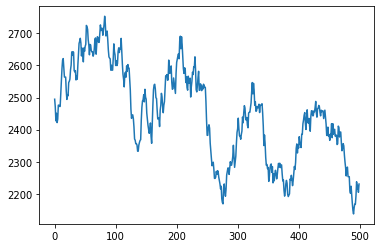

In [31]:
running_loss_average = uniform_filter1d(loss_history, size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

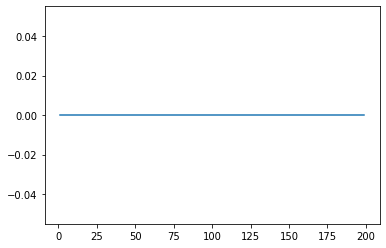

In [50]:
x = torch.Tensor(np.arange(1, 200)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

In [49]:
for para in model.parameters():
    print(para)

Parameter containing:
tensor([[-9.7780e-01],
        [ 4.4154e-01],
        [-1.1949e+00],
        [-8.9351e-01],
        [ 1.0526e-01],
        [ 4.0943e-01],
        [-6.4137e-01],
        [ 4.1573e-01],
        [-3.0757e-01],
        [ 2.2205e-01],
        [-8.3586e-01],
        [-5.9866e-01],
        [ 5.7032e-01],
        [ 6.8738e-01],
        [ 1.5736e-01],
        [-4.8791e-01],
        [ 3.1047e-01],
        [-1.5413e-02],
        [-5.3227e-01],
        [ 1.3350e+00],
        [-2.9663e-01],
        [ 7.4631e-01],
        [-9.9015e-02],
        [ 5.2839e-01],
        [-1.3755e+00],
        [ 5.2647e-01],
        [-8.0496e-01],
        [ 7.3475e-01],
        [ 1.4894e+00],
        [ 2.5023e-02],
        [-9.0184e-02],
        [-3.4828e-02],
        [ 5.7823e-01],
        [-1.8959e-01],
        [-4.6199e-01],
        [-3.9487e-01],
        [-6.5468e-02],
        [-9.6210e-01],
        [-8.6880e-01],
        [-1.1432e+00],
        [ 2.3724e-01],
        [ 3.7566e-01],
        [-2.